# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# For neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# For preprocessing and evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [ ]:
# Define a function to load data and aggregate them
def aggregate_stock_data(file_names):

    all_dfs = []

    for file_name in file_names:
        # Extract stock name from file name (remove '_stock_data.csv')
        stock_name = file_name.split('_')[0]

        # Read the CSV file
        df = pd.read_csv(file_name)

        # Convert date to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Rename columns to include stock name
        columns_to_rename = ['Open', 'High', 'Low', 'Close', 'Volume']
        rename_dict = {col: col + stock_name for col in columns_to_rename}
        df = df.rename(columns=rename_dict)

        # Drop the 'Name' column as it's redundant
        if 'Name' in df.columns:
            df = df.drop('Name', axis=1)

        all_dfs.append(df)

    # Merge all dataframes on Date
    master_df = all_dfs[0]
    for df in all_dfs[1:]:
        master_df = pd.merge(master_df, df, on='Date', how='outer')

    # Sort by date
    master_df = master_df.sort_values('Date').reset_index(drop=True)

    return master_df


In [ ]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_names = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']
master_df = aggregate_stock_data(file_names)

# View the first few rows
master_df.head()

,Date,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,...,OpenIBM,HighIBM,LowIBM,CloseIBM,VolumeIBM,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
0,2006-01-03,47.47,47.85,46.25,47.58,7582127.0,211.47,218.05,209.32,217.83,...,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418.0
1,2006-01-04,47.48,47.73,46.69,47.25,7440914.0,222.17,224.70,220.09,222.84,...,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661.0
2,2006-01-05,47.16,48.20,47.11,47.65,5417258.0,223.22,226.00,220.97,225.85,...,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610.0
3,2006-01-06,47.97,48.58,47.32,47.87,6154285.0,228.66,235.49,226.85,233.06,...,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092.0
4,2006-01-09,46.55,47.10,46.40,47.08,8945056.0,233.44,236.94,230.70,233.68,...,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836.0


In [ ]:
# View specifics of the data
print(f"Dataset shape: {master_df.shape}")
print("="*20)
print("\nColumn Data Types:")
print(master_df.dtypes)
print("="*20)
print("\nBasic Statistics:")
master_df.describe().T

Dataset shape: (3020, 21)

Column Data Types:
Date           datetime64[ns]
OpenAMZN              float64
HighAMZN              float64
LowAMZN               float64
CloseAMZN             float64
VolumeAMZN            float64
OpenGOOGL             float64
HighGOOGL             float64
LowGOOGL              float64
CloseGOOGL            float64
VolumeGOOGL           float64
OpenIBM               float64
HighIBM               float64
LowIBM                float64
CloseIBM              float64
VolumeIBM               int64
OpenMSFT              float64
HighMSFT              float64
LowMSFT               float64
CloseMSFT             float64
VolumeMSFT            float64
dtype: object

Basic Statistics:


,count,mean,min,25%,50%,75%,max,std
Date,3020,2012-01-01 14:54:59.602649088,2006-01-03 00:00:00,2009-01-01 12:00:00,2011-12-29 12:00:00,2014-12-31 12:00:00,2017-12-29 00:00:00,NaN
OpenAMZN,3019.0,299.33531,26.09,81.175,205.33,375.57,1204.88,280.120547
HighAMZN,3019.0,302.371163,26.3,82.58,208.0,379.155,1213.41,281.826442
LowAMZN,3019.0,296.037695,25.76,79.725,202.1,373.0,1191.15,277.927134
CloseAMZN,3019.0,299.376231,26.07,81.09,205.44,375.14,1195.83,279.980161
VolumeAMZN,3019.0,5931712.40212,986435.0,3137037.0,4724100.0,7135245.5,104404589.0,5122033.836727
OpenGOOGL,3019.0,428.200802,131.39,247.775,310.48,572.14,1083.02,236.320026
HighGOOGL,3019.0,431.835618,134.82,250.19,312.81,575.975,1086.49,237.514087
LowGOOGL,3019.0,424.130275,123.77,244.035,307.79,565.9,1072.27,234.923747
CloseGOOGL,3019.0,428.044001,128.85,247.605,310.08,570.77,1085.09,236.343238


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [ ]:
# Approach
# 1. Check for missing values in the dataset
# 2. Decide on an approach to handle missing values (forward fill, backward fill, or interpolation)
# 3. Apply the chosen approach and verify results

# Handle Missing Values
# Check for missing values
print("Missing values per column:")
print(master_df.isnull().sum())

# Handle missing values using forward fill followed by backward fill
# This is appropriate for time series data
master_df = master_df.fillna(method='ffill').fillna(method='bfill')

# Verify that missing values have been handled
print("\nMissing values after handling:")
print(master_df.isnull().sum())

# Additional check for any remaining issues
print(f"\nDataset shape after handling missing values: {master_df.shape}")


Missing values per column:
Date           0
OpenAMZN       1
HighAMZN       1
LowAMZN        1
CloseAMZN      1
VolumeAMZN     1
OpenGOOGL      1
HighGOOGL      1
LowGOOGL       1
CloseGOOGL     1
VolumeGOOGL    1
OpenIBM        1
HighIBM        0
LowIBM         1
CloseIBM       0
VolumeIBM      0
OpenMSFT       1
HighMSFT       1
LowMSFT        1
CloseMSFT      1
VolumeMSFT     1
dtype: int64

Missing values after handling:
Date           0
OpenAMZN       0
HighAMZN       0
LowAMZN        0
CloseAMZN      0
VolumeAMZN     0
OpenGOOGL      0
HighGOOGL      0
LowGOOGL       0
CloseGOOGL     0
VolumeGOOGL    0
OpenIBM        0
HighIBM        0
LowIBM         0
CloseIBM       0
VolumeIBM      0
OpenMSFT       0
HighMSFT       0
LowMSFT        0
CloseMSFT      0
VolumeMSFT     0
dtype: int64

Dataset shape after handling missing values: (3020, 21)


<ipython-input-6-28150fcb2933>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_df = master_df.fillna(method='ffill').fillna(method='bfill')


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

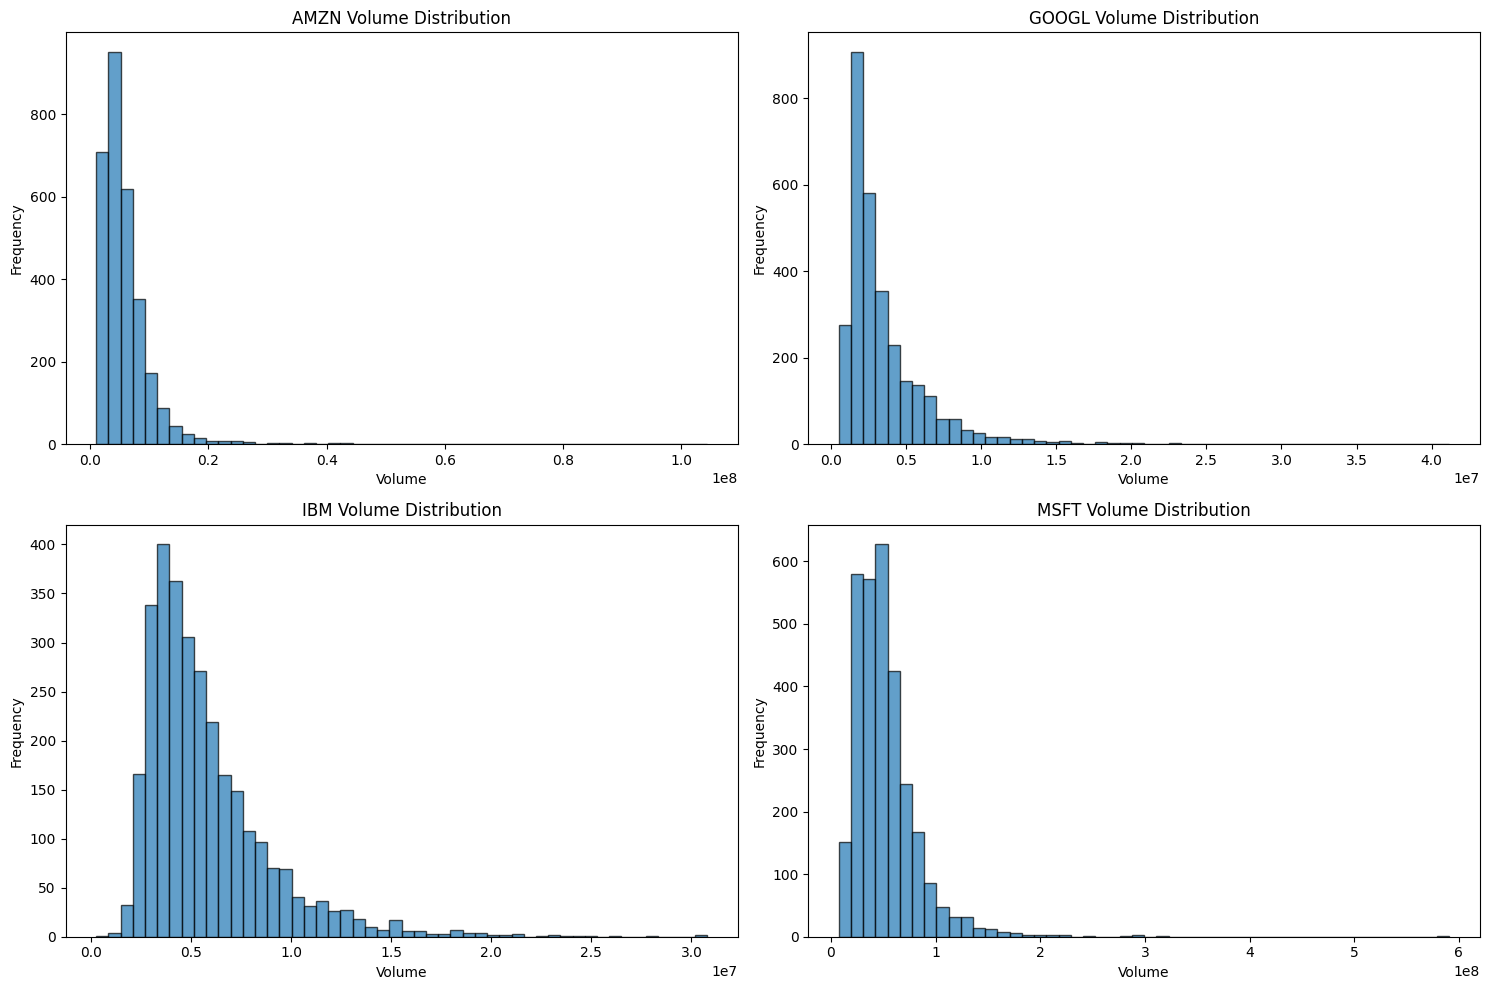

=== Volume Statistics ===
         VolumeAMZN   VolumeGOOGL     VolumeIBM    VolumeMSFT
count  3.020000e+03  3.020000e+03  3.020000e+03  3.020000e+03
mean   5.931272e+06  3.551331e+06  5.773301e+06  5.162164e+07
std    5.121243e+06  3.038111e+06  3.192831e+06  3.114520e+07
min    9.864350e+05  5.211410e+05  2.542560e+05  7.425603e+06
25%    3.137116e+06  1.760904e+06  3.622681e+06  3.136875e+07
50%    4.723865e+06  2.518196e+06  4.928852e+06  4.617739e+07
75%    7.134578e+06  4.241876e+06  6.965014e+06  6.322955e+07
max    1.044046e+08  4.118289e+07  3.077428e+07  5.910786e+08


In [ ]:
# Frequency distribution of volumes
volume_cols = [col for col in master_df.columns if 'Volume' in col]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(volume_cols):
    company = col.replace('Volume', '')
    axes[i].hist(master_df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{company} Volume Distribution')
    axes[i].set_xlabel('Volume')
    axes[i].set_ylabel('Frequency')
    axes[i].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()

# Display volume statistics
print("=== Volume Statistics ===")
volume_stats = master_df[volume_cols].describe()
print(volume_stats)


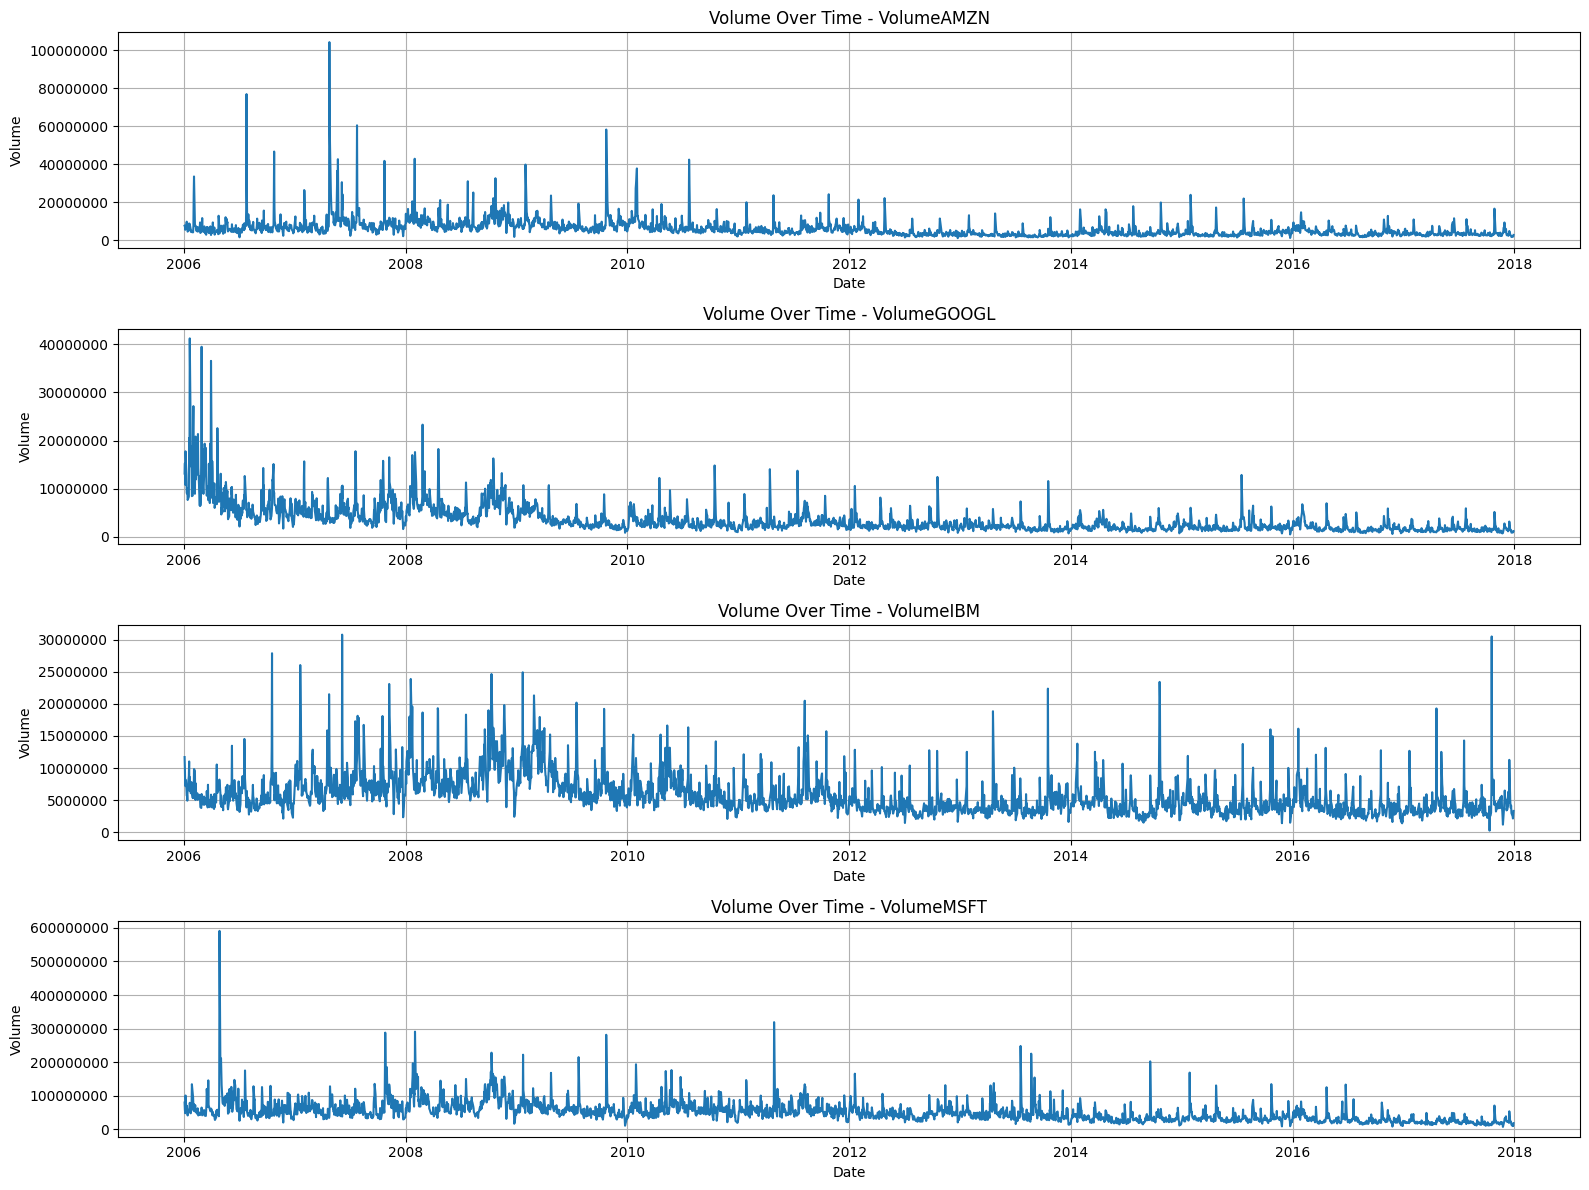

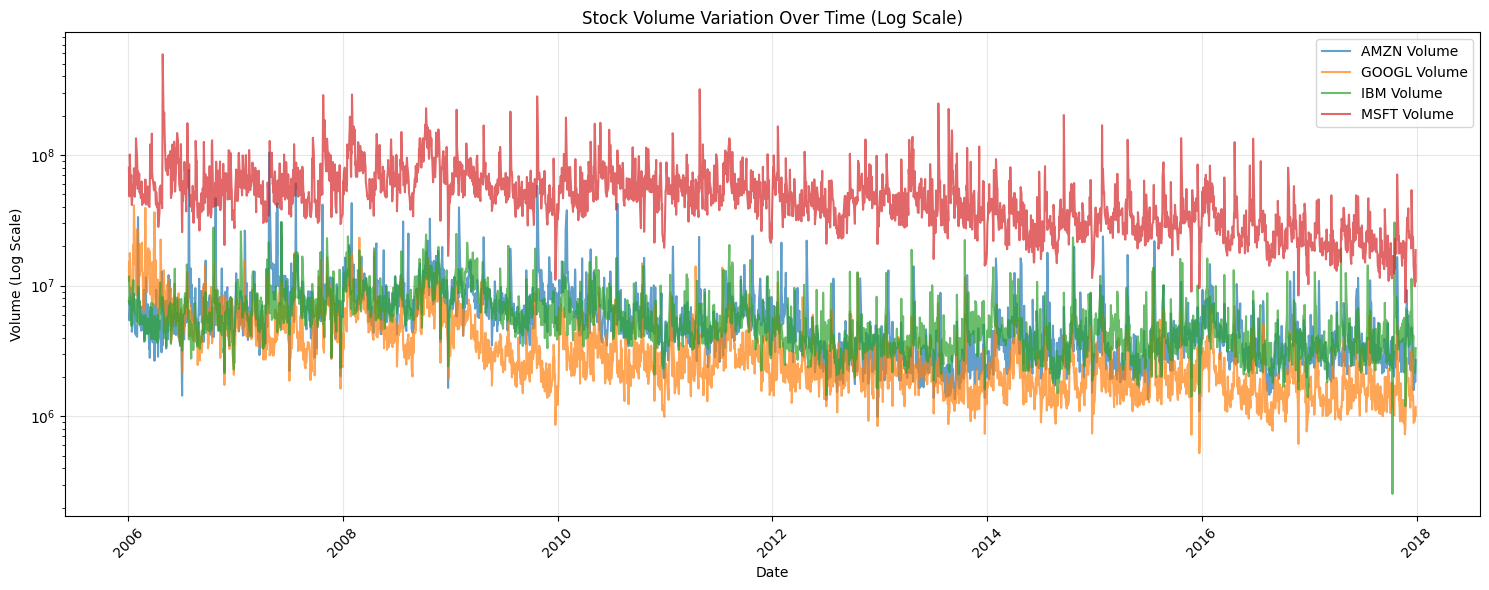

In [ ]:
# Stock volume variation over time
plt.figure(figsize=(16, 12))

# Plot time series for each volume column
for i, col in enumerate(volume_cols, 1):
    plt.subplot(len(volume_cols), 1, i)
    plt.plot(master_df['Date'], master_df[col])
    plt.title(f'Volume Over Time - {col}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.ticklabel_format(style='plain', axis='y')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plot with log scale for better visualization
plt.figure(figsize=(15, 6))

for col in volume_cols:
    company = col.replace('Volume', '')
    plt.plot(master_df['Date'], master_df[col], label=f'{company} Volume', alpha=0.7)

plt.title('Stock Volume Variation Over Time (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Volume (Log Scale)')
plt.yscale('log')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

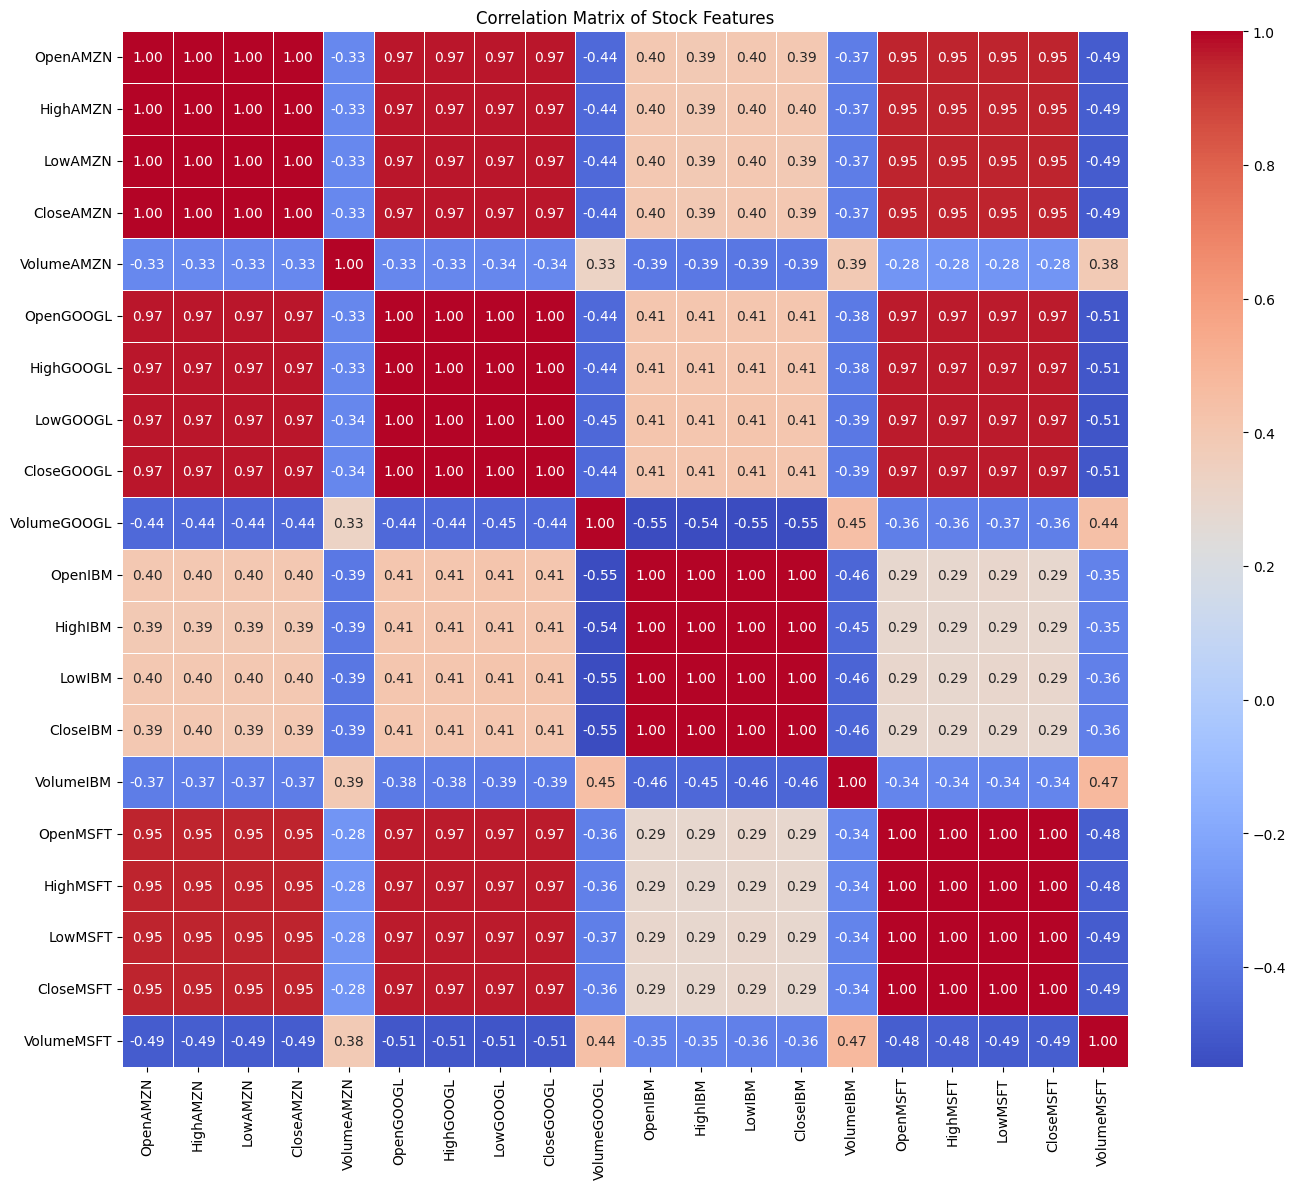

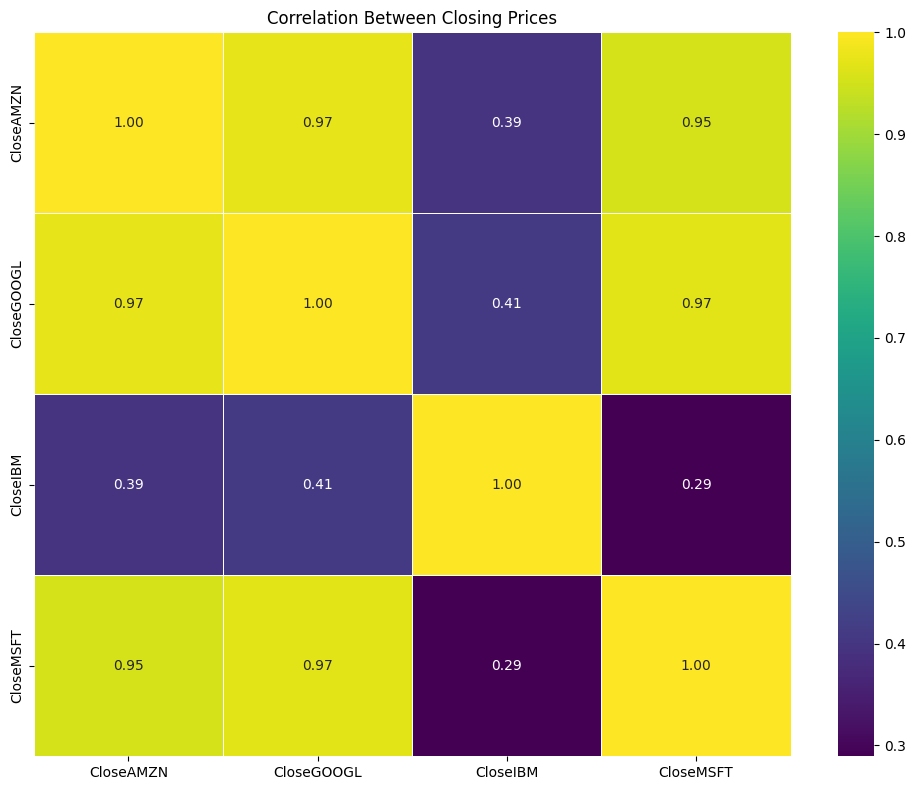

Correlation between closing prices:
            CloseAMZN  CloseGOOGL  CloseIBM  CloseMSFT
CloseAMZN    1.000000    0.972857  0.394986   0.953659
CloseGOOGL   0.972857    1.000000  0.410355   0.968974
CloseIBM     0.394986    0.410355  1.000000   0.289284
CloseMSFT    0.953659    0.968974  0.289284   1.000000


In [ ]:
# Analyse correlations
# Focus on close prices for correlation analysis
close_cols = [col for col in master_df.columns if 'Close' in col]

# Calculate correlation matrix for all features
correlation_matrix = master_df.iloc[:, 1:].corr()  # Skip the Date column

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Stock Features')
plt.tight_layout()
plt.show()

# Focus on close price correlations specifically
close_corr = master_df[close_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(close_corr, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Closing Prices')
plt.tight_layout()
plt.show()

# Print the correlation values for close prices
print("Correlation between closing prices:")
print(close_corr)

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [ ]:
# Define a function that divides the data into windows and generates target variable values for each window
# Approach:
# 1. Create a function to generate windows of a specified size
# 2. For each window, extract features (X) and target values (y)
# 3. Ensure target values are aligned correctly with the input windows
# 4. Return the windowed X and y data

def create_windows(df, window_size, step_size, target_names):
    """
    Creates windowed X and y data for time series prediction.

    Parameters:
    -----------
    df : pd.DataFrame
        The master dataframe with all stock data
    window_size : int
        Size of each window (number of time steps to include)
    step_size : int
        Step size between windows (stride)
    target_names : list
        List of column names to predict

    Returns:
    --------
    X_windows : list
        List of dataframes, each representing a window of input features
    y_values : numpy.ndarray
        Array of target values for each window
    """
    # Initialize empty lists for X windows and y values
    X_windows = []
    y_values = []

    # Loop through the dataframe to create windows
    for i in range(0, len(df) - window_size - 1, step_size):
        window = df.iloc[i : i+window_size].copy()

        # Extract target values (next day's closing prices)
        target_vals = df.iloc[i+window_size][target_names].values

        # Drop the Date column as it's not useful for prediction
        if 'Date' in window.columns:
            window = window.drop('Date', axis=1)

        # Append to the lists
        X_windows.append(window)
        y_values.append(target_vals)

    # Convert y_values to numpy array
    y_values = np.array(y_values)

    return X_windows, y_values


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [ ]:
# Define a function that scales the windowed data

# Approach:
# 1. Create a function to scale each window independently
# 2. Apply scaler to each window to avoid data leakage
# 3. Scale target values appropriately
# 4. Return the scaled data

def scale_windowed_data(X_windows_train, X_windows_test, y_train, y_test, scaling_method='minmax'):
    """
    Scales the windowed data using either MinMaxScaler or StandardScaler.

    Parameters:
    -----------
    X_windows_train : list
        List of dataframes for training features
    X_windows_test : list
        List of dataframes for testing features
    y_train : numpy.ndarray
        Array of training target values
    y_test : numpy.ndarray
        Array of testing target values
    scaling_method : str
        Scaling method to use ('minmax' or 'standard')

    Returns:
    --------
    X_train_scaled : numpy.ndarray
        Scaled training features
    X_test_scaled : numpy.ndarray
        Scaled testing features
    y_train_scaled : numpy.ndarray
        Scaled training targets
    y_test_scaled : numpy.ndarray
        Scaled testing targets
    feature_scaler : scaler object
        The scaler used for features
    target_scaler : scaler object
        The scaler used for targets
    """
    # Choose scaler based on the method parameter
    if scaling_method == 'minmax':
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()
    else:
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()

    # Convert windows to arrays for scaling
    X_train_array = np.array([window.values for window in X_windows_train])
    X_test_array = np.array([window.values for window in X_windows_test])

    # Get original shapes to reshape back after scaling
    train_samples, train_timesteps, train_features = X_train_array.shape
    test_samples, test_timesteps, test_features = X_test_array.shape

    # Reshape to 2D for scaling
    X_train_reshaped = X_train_array.reshape(-1, train_features)
    X_test_reshaped = X_test_array.reshape(-1, test_features)

    # Fit the scaler on training data only and transform both train and test
    feature_scaler.fit(X_train_reshaped)
    X_train_scaled_reshaped = feature_scaler.transform(X_train_reshaped)
    X_test_scaled_reshaped = feature_scaler.transform(X_test_reshaped)

    # Reshape back to 3D
    X_train_scaled = X_train_scaled_reshaped.reshape(train_samples, train_timesteps, train_features)
    X_test_scaled = X_test_scaled_reshaped.reshape(test_samples, test_timesteps, test_features)

    # Scale target values
    target_scaler.fit(y_train)
    y_train_scaled = target_scaler.transform(y_train)
    y_test_scaled = target_scaler.transform(y_test)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [ ]:
# Define a function to create input and output data points from the master DataFrame

# Approach:
# 1. Define a function that uses the window creation and scaling functions
# 2. Split the windows into training and testing sets
# 3. Scale the data appropriately
# 4. Return all necessary components for model building

def prepare_data_for_rnn(df, target_names, window_size=30, step_size=1, test_split=0.2, scaling_method='minmax'):
    """
    Prepares data for RNN models by creating windows, splitting into train/test, and scaling.

    Parameters:
    -----------
    df : pd.DataFrame
        The master dataframe with all stock data
    target_names : list
        List of column names to predict
    window_size : int
        Size of each window (number of time steps to include)
    step_size : int
        Step size between windows (stride)
    test_split : float
        Proportion of data to use for testing
    scaling_method : str
        Scaling method to use ('minmax' or 'standard')

    Returns:
    --------
    X_train_scaled : numpy.ndarray
        Scaled training features
    X_test_scaled : numpy.ndarray
        Scaled testing features
    y_train_scaled : numpy.ndarray
        Scaled training targets
    y_test_scaled : numpy.ndarray
        Scaled testing targets
    feature_scaler : scaler object
        The scaler used for features
    target_scaler : scaler object
        The scaler used for targets
    """
    # Create windows
    X_windows, y_values = create_windows(df, window_size, step_size, target_names)

    # Get the number of samples for training
    n_samples = len(X_windows)
    split_idx = int(n_samples * (1 - test_split))

    # Split into training and testing sets
    X_windows_train = X_windows[:split_idx]
    X_windows_test = X_windows[split_idx:]
    y_train = y_values[:split_idx]
    y_test = y_values[split_idx:]

    # Scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_windowed_data(
        X_windows_train, X_windows_test, y_train, y_test, scaling_method
    )

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

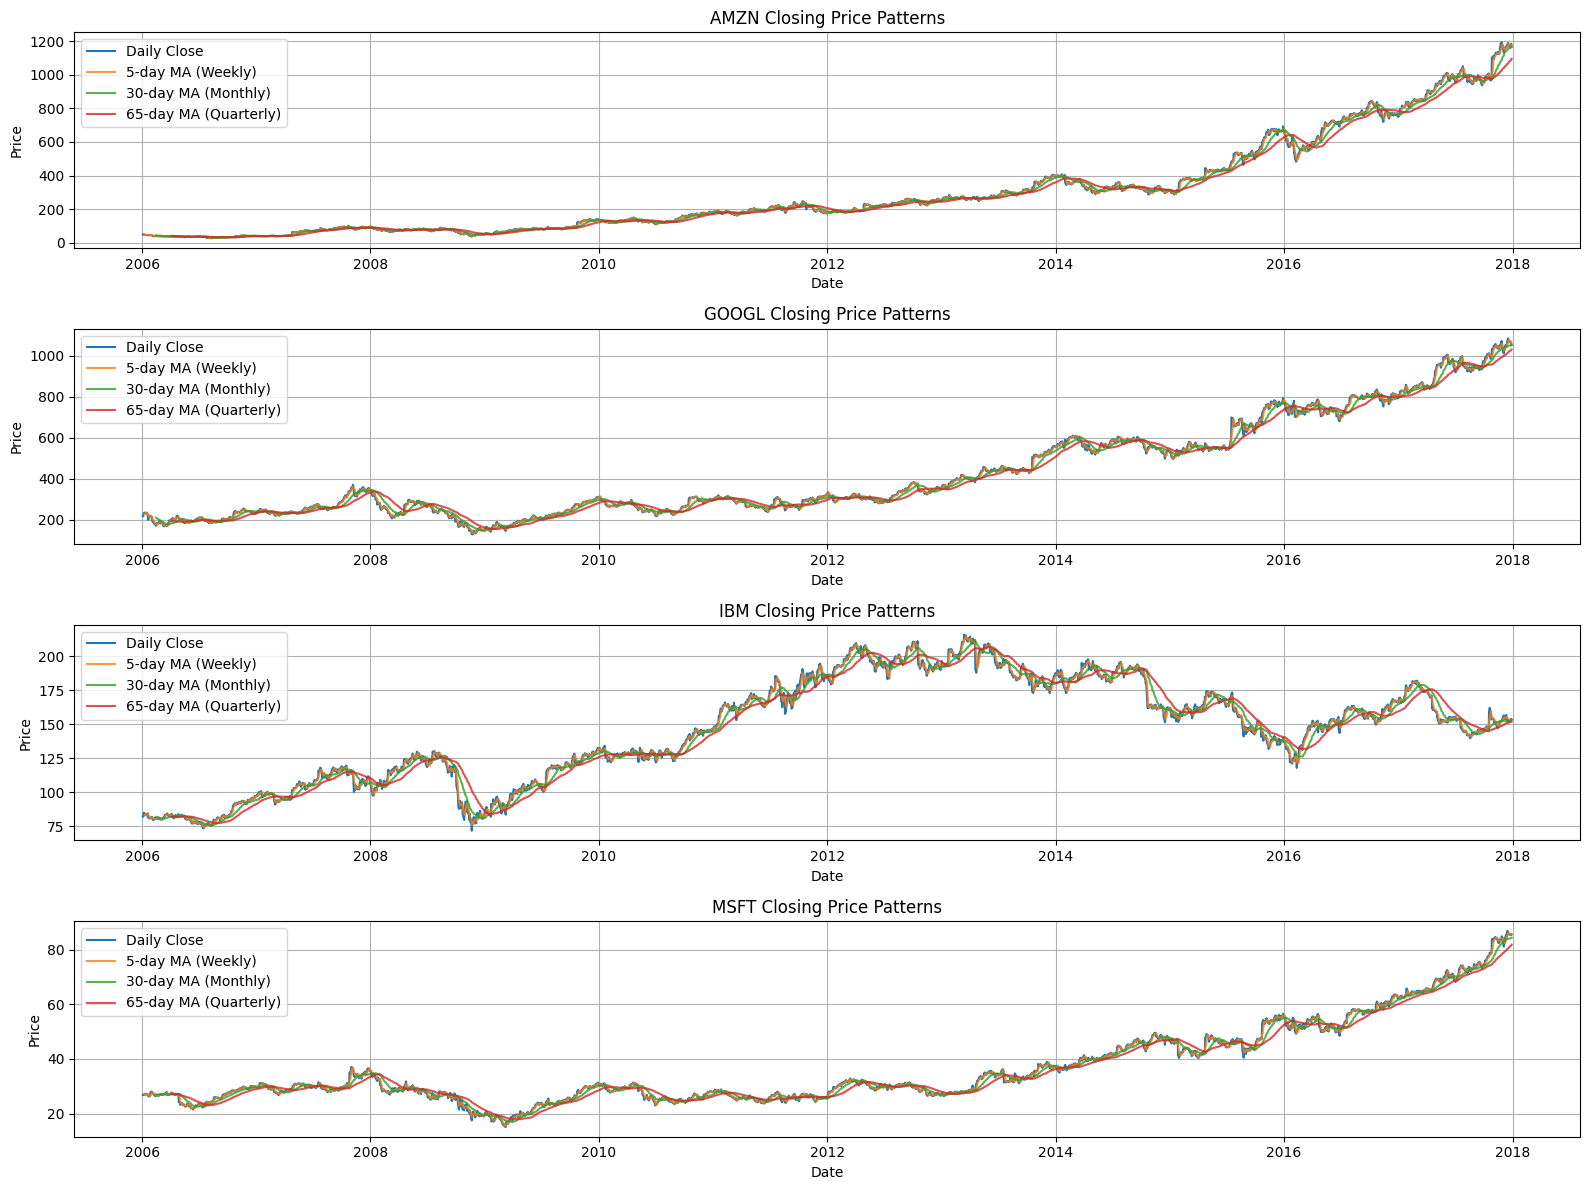

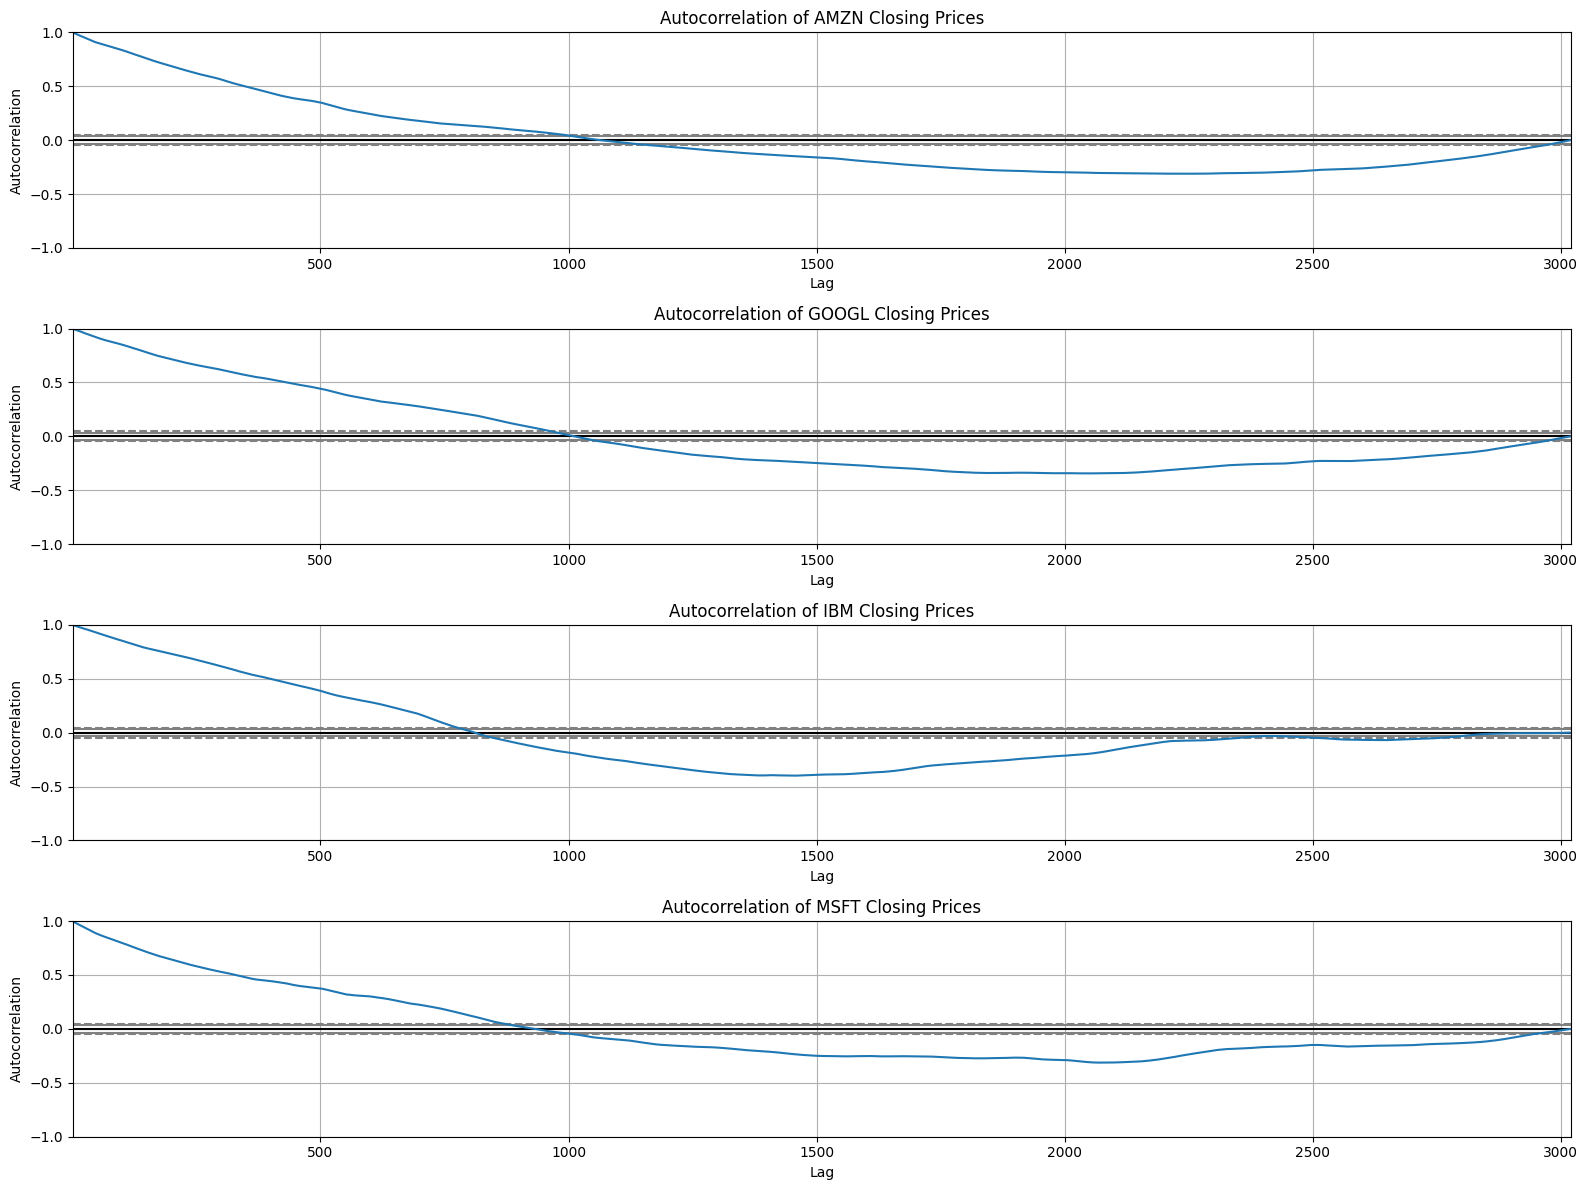

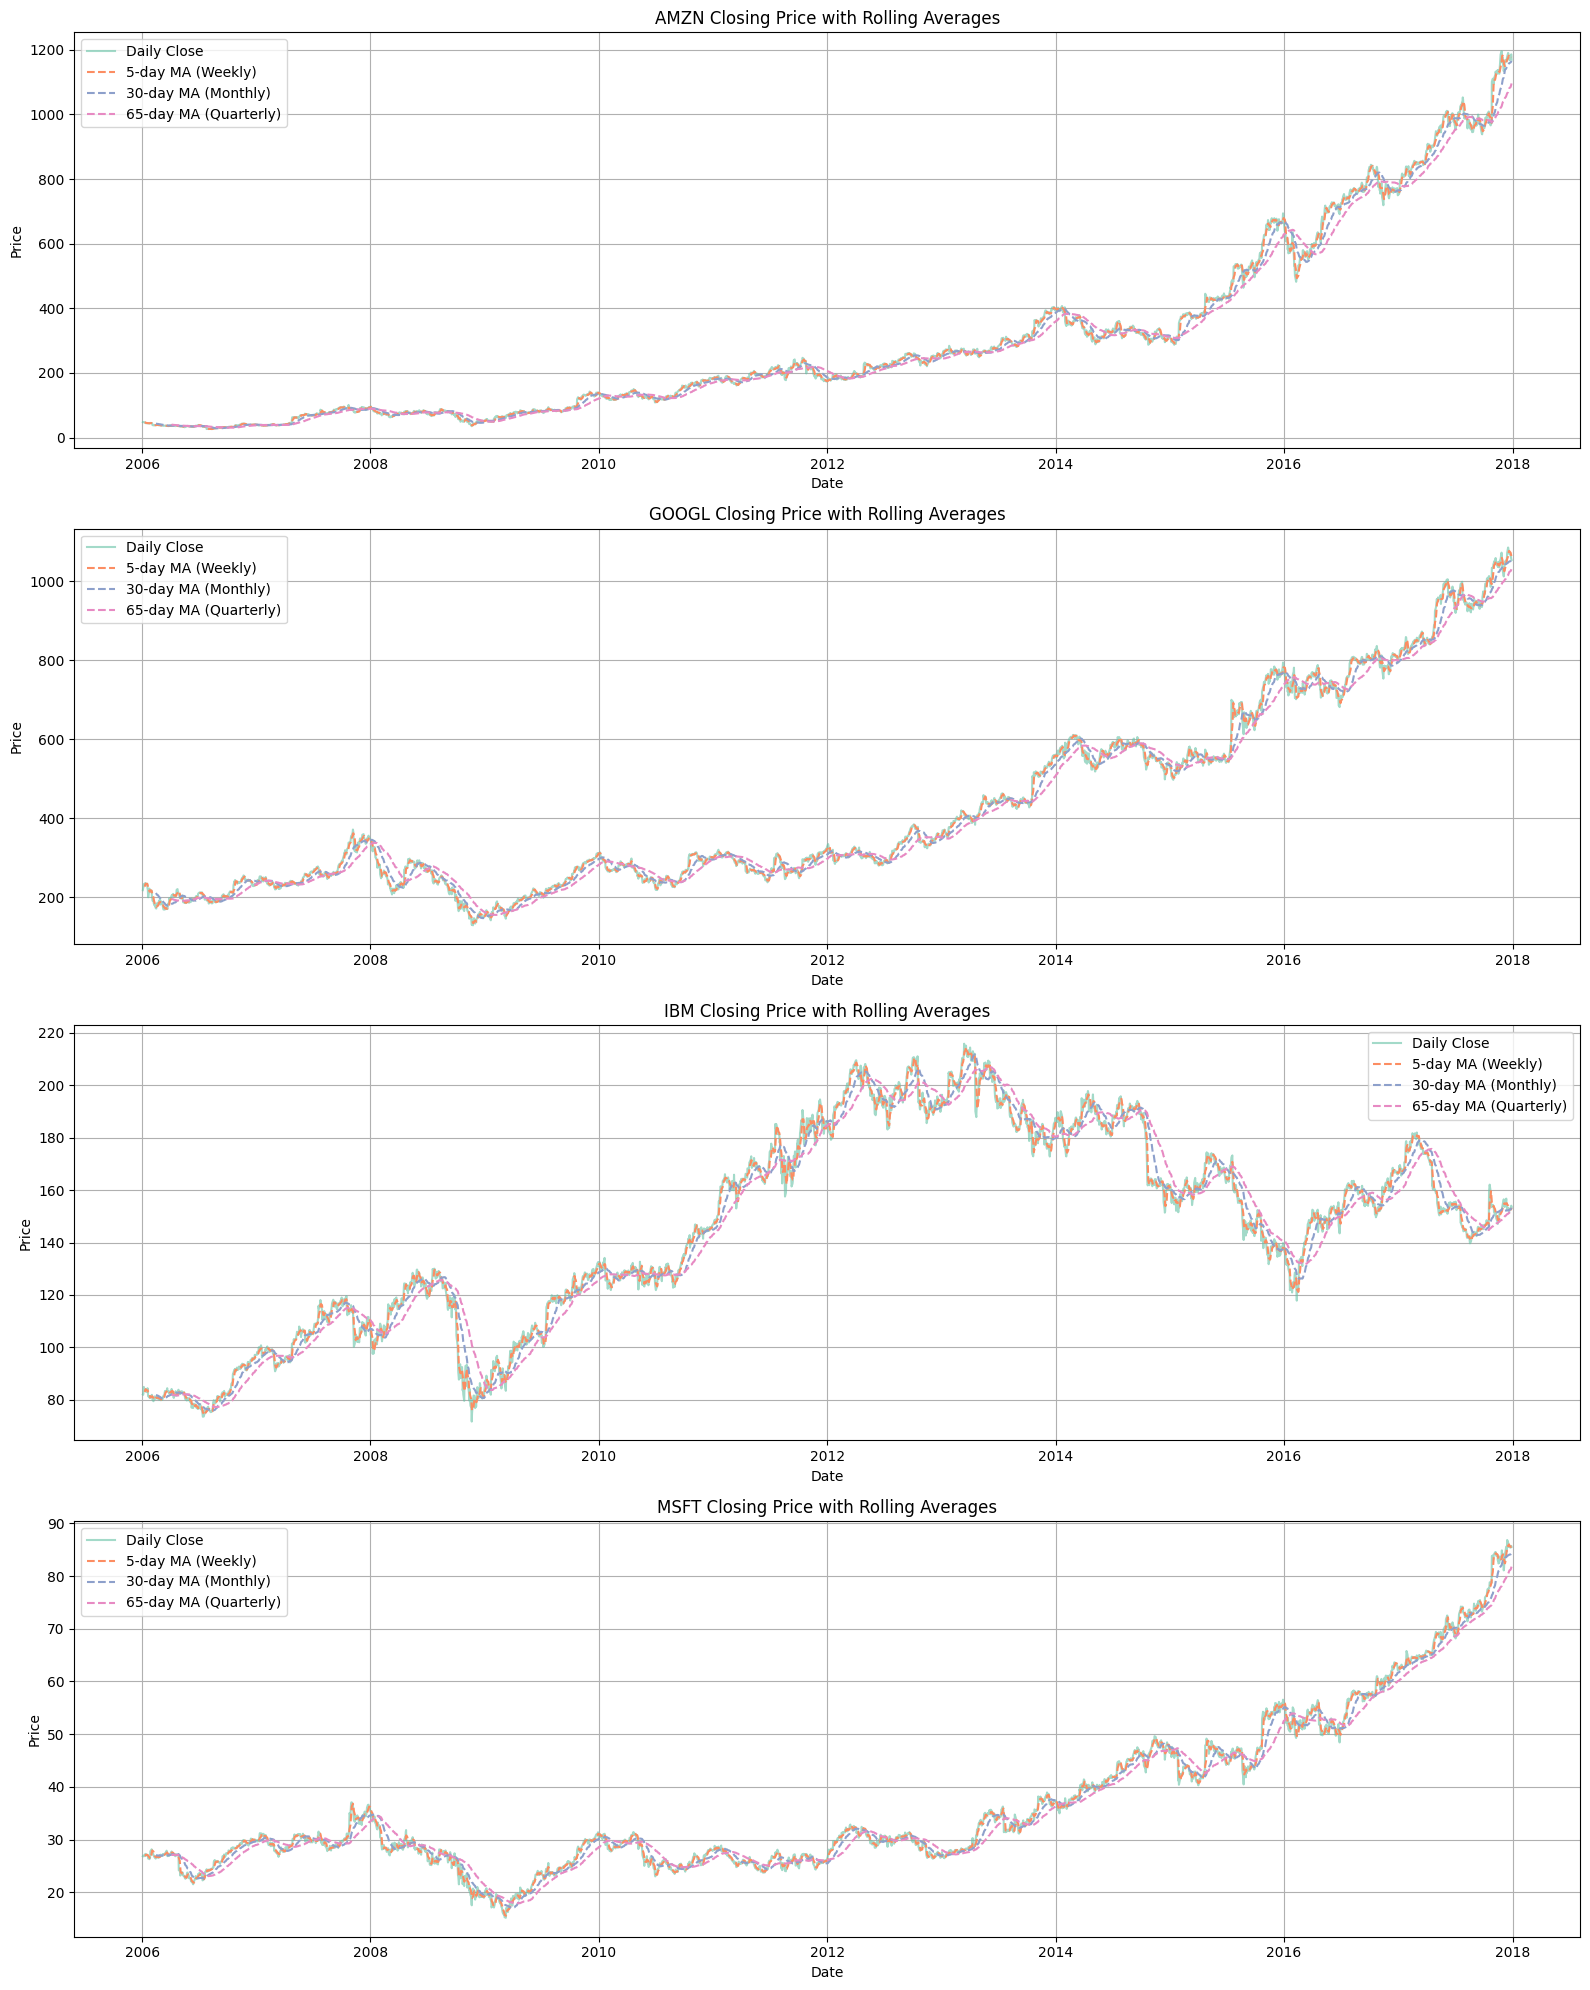

Chosen window size: 30 (representing a approximately 1 business month)
This window size captures longer-term patterns while providing sufficient data points for training.


In [ ]:
# Checking for patterns in different sequence lengths

# Approach:
# 1. Analyze time series data at different frequencies (weeks, months, quarters)
# 2. Plot closing prices to identify patterns
# 3. Determine appropriate window size based on observed patterns

plt.figure(figsize=(16, 12))

# Weekly pattern (5 business days in a week)
weekly_window = 5

# Monthly pattern (roughly 30 business days in a month)
monthly_window = 30

# Quarterly pattern (roughly 65 business days in a quarter)
quarterly_window = 65

# Plot different companies' closing prices
close_cols = [col for col in master_df.columns if 'Close' in col]
companies = [col.replace('Close', '') for col in close_cols]

# Plot for each company
for i, (col, company) in enumerate(zip(close_cols, companies), 1):
    plt.subplot(len(close_cols), 1, i)

    # Plot the full time series
    plt.plot(master_df['Date'], master_df[col], label='Daily Close')

    # Plot rolling averages
    plt.plot(master_df['Date'], master_df[col].rolling(window=weekly_window).mean(),
             label=f'{weekly_window}-day MA (Weekly)', alpha=0.8)
    plt.plot(master_df['Date'], master_df[col].rolling(window=monthly_window).mean(),
             label=f'{monthly_window}-day MA (Monthly)', alpha=0.8)
    plt.plot(master_df['Date'], master_df[col].rolling(window=quarterly_window).mean(),
             label=f'{quarterly_window}-day MA (Quarterly)', alpha=0.8)

    plt.title(f'{company} Closing Price Patterns')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Let's also check autocorrelation to find patterns
plt.figure(figsize=(16, 12))

for i, (col, company) in enumerate(zip(close_cols, companies), 1):
    plt.subplot(len(close_cols), 1, i)
    pd.plotting.autocorrelation_plot(master_df[col])
    plt.title(f'Autocorrelation of {company} Closing Prices')
    plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(16, 5 * len(close_cols)))
colors = sns.color_palette("Set2", 4)

for i, (col, company) in enumerate(zip(close_cols, companies), 1):
    plt.subplot(len(close_cols), 1, i)

    plt.plot(master_df['Date'], master_df[col], label='Daily Close', color=colors[0], alpha=0.6)
    plt.plot(master_df['Date'], master_df[col].rolling(window=weekly_window).mean(),
             label=f'{weekly_window}-day MA (Weekly)', color=colors[1], linestyle='--')
    plt.plot(master_df['Date'], master_df[col].rolling(window=monthly_window).mean(),
             label=f'{monthly_window}-day MA (Monthly)', color=colors[2], linestyle='--')
    plt.plot(master_df['Date'], master_df[col].rolling(window=quarterly_window).mean(),
             label=f'{quarterly_window}-day MA (Quarterly)', color=colors[3], linestyle='--')

    plt.title(f'{company} Closing Price with Rolling Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# 30-day MA(Moving Avg.) (Monthly) offers the best trade-off between noise reduction and trend responsiveness.
# 65-day MA smooths too much and may delay signals.
# 5-day MA is too volatile for trend tracking.

# Based on the analysis, choose a window size (monthly seems appropriate as explained below)
window_size = 30
print(f"Chosen window size: {window_size} (representing a approximately 1 business month)")
print("This window size captures longer-term patterns while providing sufficient data points for training.")


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride
# Based on above graphs we can say that
# 30-day MA(Moving Avg.) (Monthly) offers the best trade-off between noise reduction and trend responsiveness.
# 65-day MA smooths too much and may delay signals.
# 5-day MA is too volatile for trend tracking.

window_size = 30
step_size = 1
test_split = 0.2

# We'll predict closing prices for all four companies
target_names = ['CloseAMZN', 'CloseGOOGL', 'CloseIBM', 'CloseMSFT']

# Initially, let's focus on predicting one company's closing price
single_target = ['CloseAMZN']

# Prepare data for single target prediction
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = prepare_data_for_rnn(
    master_df, single_target, window_size, step_size, test_split, 'minmax'
)

# Print shapes to understand the data dimensions
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"y_test shape: {y_test_scaled.shape}")


X_train shape: (2391, 30, 20)
X_test shape: (598, 30, 20)
y_train shape: (2391, 1)
y_test shape: (598, 1)


In [ ]:
# Check the number of data points generated
print("Training samples:", len(X_train_scaled))
print("Testing samples:", len(X_test_scaled))
print("Total samples:", len(X_train_scaled) + len(X_test_scaled))

# Detailed dimensions
print("\nDetailed dimensions:")
print(f"X_train: {X_train_scaled.shape} (samples, time steps, features)")
print(f"y_train: {y_train_scaled.shape} (samples, targets)")
print(f"X_test: {X_test_scaled.shape} (samples, time steps, features)")
print(f"y_test: {y_test_scaled.shape} (samples, targets)")

Training samples: 2391
Testing samples: 598
Total samples: 2989

Detailed dimensions:
X_train: (2391, 30, 20) (samples, time steps, features)
y_train: (2391, 1) (samples, targets)
X_test: (598, 30, 20) (samples, time steps, features)
y_test: (598, 1) (samples, targets)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks
# Check data types
print("Data types:")
print(f"X_train_scaled: {X_train_scaled.dtype}")
print(f"y_train_scaled: {y_train_scaled.dtype}")
print(f"X_test_scaled: {X_test_scaled.dtype}")
print(f"y_test_scaled: {y_test_scaled.dtype}")

# Check for NaN or infinite values
print("\nChecking for NaN or infinite values:")
print(f"X_train has NaN: {np.isnan(X_train_scaled).any()}")
print(f"X_train has inf: {np.isinf(X_train_scaled).any()}")
print(f"y_train has NaN: {np.isnan(y_train_scaled).any()}")
print(f"y_train has inf: {np.isinf(y_train_scaled).any()}")
print(f"X_test has NaN: {np.isnan(X_test_scaled).any()}")
print(f"X_test has inf: {np.isinf(X_test_scaled).any()}")
print(f"y_test has NaN: {np.isnan(y_test_scaled).any()}")
print(f"y_test has inf: {np.isinf(y_test_scaled).any()}")

# Verify shapes for RNN input
num_features = X_train_scaled.shape[2]
num_targets = y_train_scaled.shape[1]

print("\nShape verification:")
print(f"Number of time steps (window size): {window_size}")
print(f"Number of features: {num_features}")
print(f"Number of targets: {num_targets}")
print(f"Data is {'compatible' if X_train_scaled.shape[1] == window_size else 'not compatible'} with RNN input requirements")


Data types:
X_train_scaled: float64
y_train_scaled: float64
X_test_scaled: float64
y_test_scaled: float64

Checking for NaN or infinite values:
X_train has NaN: False
X_train has inf: False
y_train has NaN: False
y_train has inf: False
X_test has NaN: False
X_test has inf: False
y_test has NaN: False
y_test has inf: False

Shape verification:
Number of time steps (window size): 30
Number of features: 20
Number of targets: 1
Data is compatible with RNN input requirements


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn_model(input_shape, output_dim, units=64, dropout_rate=0.2,
                           learning_rate=0.001, hidden_layers=1, activation='tanh'):
    """
    Creates a simple RNN model with the specified configuration.

    Parameters:
    - input_shape: Shape of input data (time_steps, features)
    - output_dim: Dimension of output (number of target variables)
    - units: Number of units in each RNN layer
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for the optimizer
    - hidden_layers: Number of hidden RNN layers
    - activation: Activation function for the RNN layers

    Returns:
    - model: Compiled Keras model
    """
    model = Sequential()

    # Add RNN layers
    if hidden_layers == 1:
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           input_shape=input_shape,
                           return_sequences=False))
        model.add(Dropout(dropout_rate))
    else:
        # First layer
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           input_shape=input_shape,
                           return_sequences=True))
        model.add(Dropout(dropout_rate))

        # Hidden layers
        for i in range(hidden_layers - 2):
            model.add(SimpleRNN(units=units,
                               activation=activation,
                               return_sequences=True))
            model.add(Dropout(dropout_rate))

        # Last RNN layer
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           return_sequences=False))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_dim))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN
# Define hyperparameter values to test
hidden_layers_options = [1, 2]
units_options = [32, 64, 128]
dropout_rate_options = [0.1, 0.2, 0.3]
learning_rate_options = [0.005, 0.001]
activation_options = ['tanh', 'relu']
max_combinations = 30  # Maximum number of random combinations to try

# Define input shape and output dimension
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
output_dim = y_train_scaled.shape[1]

# Create a list to store results
results = []

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Keep track of combinations we've already tried to avoid duplicates
tried_combinations = set()

# Generate and test random combinations
count = 0
while count < max_combinations:
    # Randomly select one value from each hyperparameter option
    hidden_layers = random.choice(hidden_layers_options)
    units = random.choice(units_options)
    dropout_rate = random.choice(dropout_rate_options)
    learning_rate = random.choice(learning_rate_options)
    activation = random.choice(activation_options)

    # Create a tuple representing this combination
    combination = (hidden_layers, units, dropout_rate, learning_rate, activation)

    # Skip if we've already tried this combination
    if combination in tried_combinations:
        continue

    # Add to our set of tried combinations
    tried_combinations.add(combination)
    count += 1

    print(f"Training combination {count}/{max_combinations}: hidden_layers={hidden_layers}, units={units}, "
          f"dropout={dropout_rate}, learning_rate={learning_rate}, activation={activation}")

    # Create the model with the current configuration
    model = create_simple_rnn_model(
        input_shape=input_shape,
        output_dim=output_dim,
        units=units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        hidden_layers=hidden_layers,
        activation=activation
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate on the test set
    test_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

    # Store the results
    results.append({
        'hidden_layers': hidden_layers,
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'activation': activation,
        'val_loss': min(history.history['val_loss']),
        'test_loss': test_loss,
        'epochs': len(history.history['loss'])
    })

    # Clear memory
    tf.keras.backend.clear_session()

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

Training combination 1/30: hidden_layers=2, units=64, dropout=0.3, learning_rate=0.005, activation=relu
Training combination 2/30: hidden_layers=2, units=32, dropout=0.3, learning_rate=0.005, activation=relu
Training combination 3/30: hidden_layers=2, units=128, dropout=0.1, learning_rate=0.001, activation=tanh
Training combination 4/30: hidden_layers=2, units=64, dropout=0.2, learning_rate=0.001, activation=tanh
Training combination 5/30: hidden_layers=2, units=32, dropout=0.3, learning_rate=0.005, activation=tanh
Training combination 6/30: hidden_layers=2, units=128, dropout=0.1, learning_rate=0.005, activation=tanh
Training combination 7/30: hidden_layers=1, units=64, dropout=0.2, learning_rate=0.005, activation=tanh
Training combination 8/30: hidden_layers=1, units=64, dropout=0.2, learning_rate=0.005, activation=relu
Training combination 9/30: hidden_layers=2, units=64, dropout=0.2, learning_rate=0.005, activation=relu
Training combination 10/30: hidden_layers=2, units=128, dropou

Top 5 best configurations:
    hidden_layers  units  dropout_rate  learning_rate activation  val_loss  \
6               1     64           0.2          0.005       tanh  0.000339   
13              1    128           0.2          0.001       tanh  0.000395   
11              1     64           0.3          0.005       tanh  0.000448   
23              1    128           0.1          0.005       relu  0.000599   
12              1     64           0.3          0.005       relu  0.000718   

    test_loss  epochs  
6    0.035780      21  
13   0.054990      20  
11   0.042410      14  
23   0.041134      18  
12   0.036582      17  

Best configuration:
hidden_layers: 1
units: 64
dropout_rate: 0.2
learning_rate: 0.005
activation: tanh
val_loss: 0.00033946248004212976
test_loss: 0.03578022122383118
epochs: 21
Best validation loss: 0.000339


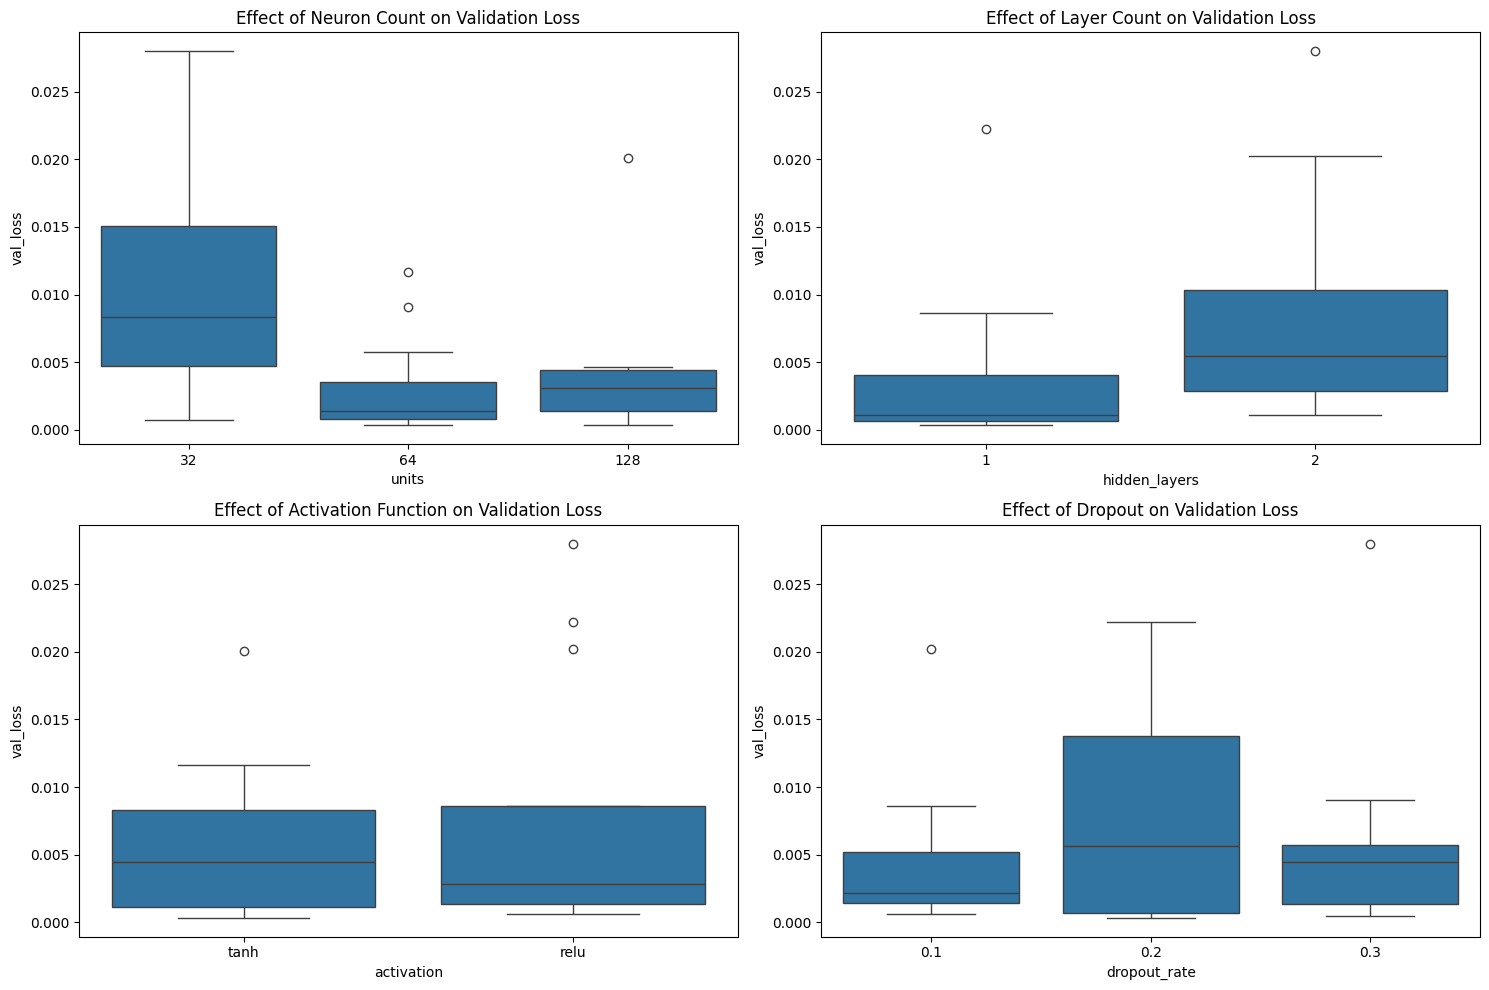

In [ ]:
# Find the best configuration based on evaluation metrics
# Sort results by validation loss
results_df = results_df.sort_values('val_loss')

# Display top 5 configurations
print("Top 5 best configurations:")
print(results_df.head())

# Identify the best configuration
best_params = results_df.iloc[0]
print("\nBest configuration:")
for param, value in best_params.items():
    print(f"{param}: {value}")

best_val_loss = best_params['val_loss']
print(f"Best validation loss: {best_val_loss:.6f}")

# Visualize impact of parameters on validation loss
plt.figure(figsize=(15, 10))

# Plot neurons vs. validation loss
plt.subplot(2, 2, 1)
sns.boxplot(x='units', y='val_loss', data=results_df)
plt.title('Effect of Neuron Count on Validation Loss')

# Plot layers vs. validation loss
plt.subplot(2, 2, 2)
sns.boxplot(x='hidden_layers', y='val_loss', data=results_df)
plt.title('Effect of Layer Count on Validation Loss')

# Plot activation function vs. validation loss
plt.subplot(2, 2, 3)
sns.boxplot(x='activation', y='val_loss', data=results_df)
plt.title('Effect of Activation Function on Validation Loss')

# Plot dropout vs. validation loss
plt.subplot(2, 2, 4)
sns.boxplot(x='dropout_rate', y='val_loss', data=results_df)
plt.title('Effect of Dropout on Validation Loss')

plt.tight_layout()
plt.show()


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,505 (21.50 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0831 - val_loss: 0.0034
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 6.1394e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 9.1718e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 8.5113e-04
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4161e-04 - val_loss: 0.0026
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0267e-04 - val_loss: 3.6762e-04
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0612e-04 - val_loss: 3.3916e-04
Epoch 12/100
60/60 ━━━━━━━━━━━

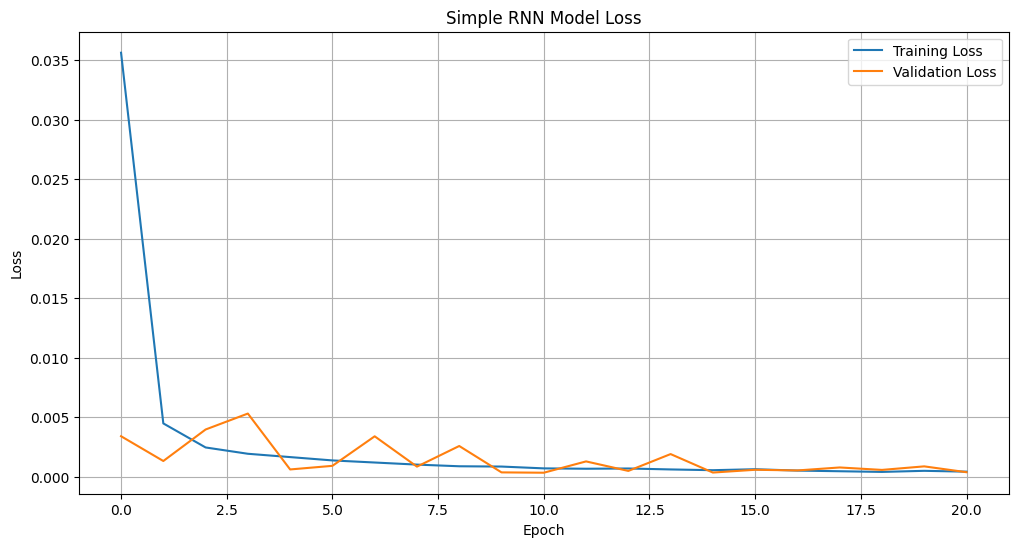

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
# Use the best parameters identified in the previous step
best_hidden_layers = int(best_params['hidden_layers']) # Ensure hidden_layers is an integer
best_units = int(best_params['units']) # Ensure units is an integer
best_dropout_rate = best_params['dropout_rate']
best_learning_rate = best_params['learning_rate']
best_activation = best_params['activation']

tf.keras.backend.clear_session()

# Create the model with best hyperparameters
best_simple_rnn_model = create_simple_rnn_model(
    input_shape=input_shape,
    output_dim=output_dim,
    units=best_units,
    dropout_rate=best_dropout_rate,
    learning_rate=best_learning_rate,
    hidden_layers=best_hidden_layers,
    activation=best_activation
)

# Print model summary
best_simple_rnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with the optimal configuration
history = best_simple_rnn_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
best_simple_rnn_model.save('best_simple_rnn_model.h5')

Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


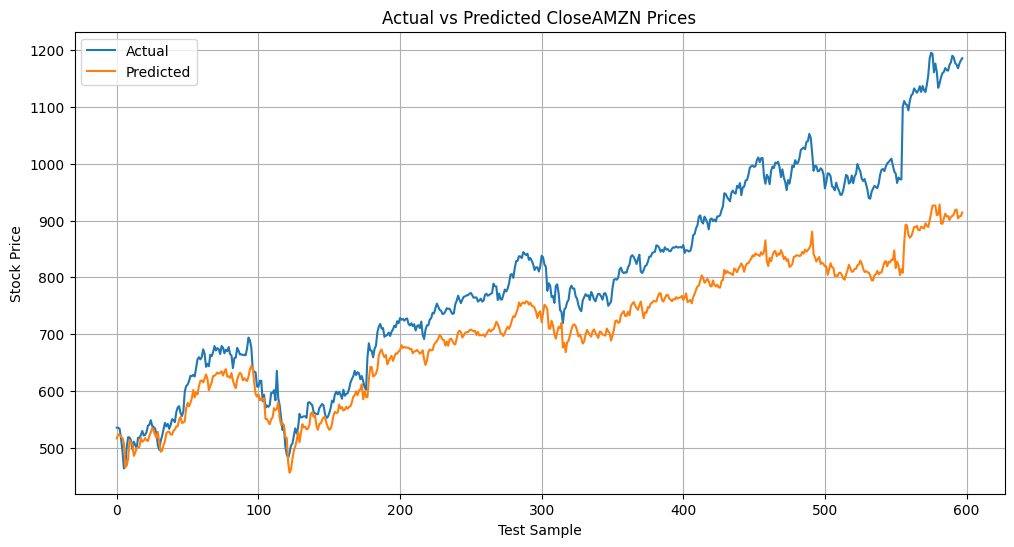

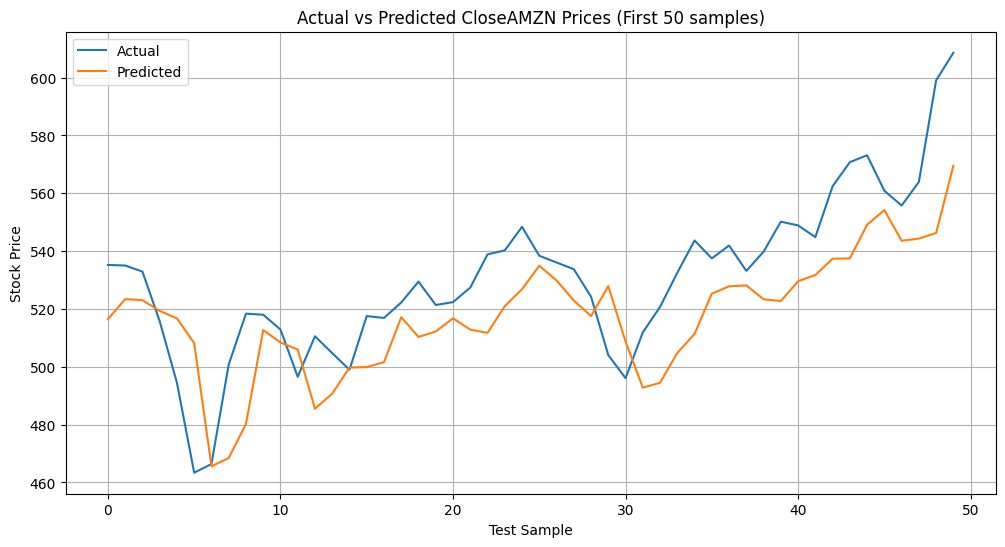

In [ ]:
# Predict on the test data and plot
# Make predictions
y_pred_scaled = best_simple_rnn_model.predict(X_test_scaled)

# Inverse transform to get actual values
y_test_actual = target_scaler.inverse_transform(y_test_scaled)
y_pred_actual = target_scaler.inverse_transform(y_pred_scaled)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.title(f'Actual vs Predicted {single_target[0]} Prices')
plt.xlabel('Test Sample')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot a subset of data for better visualization
subset_size = min(50, len(y_test_actual))
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:subset_size], label='Actual')
plt.plot(y_pred_actual[:subset_size], label='Predicted')
plt.title(f'Actual vs Predicted {single_target[0]} Prices (First {subset_size} samples)')
plt.xlabel('Test Sample')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

Simple RNN Model Performance Metrics:
Mean Squared Error (MSE): 12413.7922
Root Mean Squared Error (RMSE): 111.4172
Mean Absolute Error (MAE): 89.0126
R-squared (R²): 0.6105
Mean Absolute Percentage Error (MAPE): 10.02%


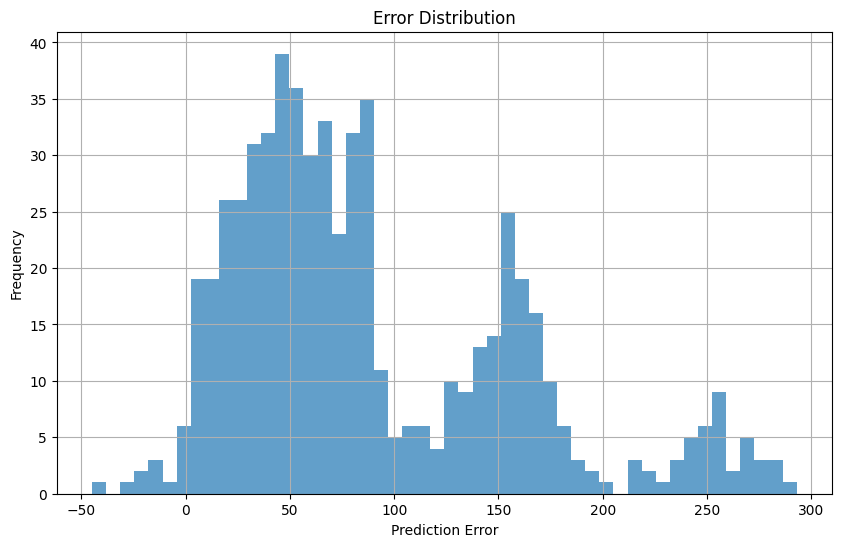

In [ ]:
# Compute the performance of the model on the testing data set
# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Simple RNN Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Calculate percentage error
pct_error = np.abs((y_test_actual - y_pred_actual) / y_test_actual) * 100
mean_pct_error = np.mean(pct_error)
print(f"Mean Absolute Percentage Error (MAPE): {mean_pct_error:.2f}%")

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(y_test_actual - y_pred_actual, bins=50, alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# Define a function to create a model and specify default values for hyperparameters
def create_advanced_rnn_model(input_shape, output_dim, model_type='LSTM', units=64,
                             dropout_rate=0.2, learning_rate=0.001, hidden_layers=1,
                             activation='tanh', bidirectional=False, regularization=None):
    """
    Creates an advanced RNN model (LSTM or GRU) with the specified configuration.

    Parameters:
    - input_shape: Shape of input data (time_steps, features)
    - output_dim: Dimension of output (number of target variables)
    - model_type: Type of RNN cell ('LSTM' or 'GRU')
    - units: Number of units in each RNN layer
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for the optimizer
    - hidden_layers: Number of hidden RNN layers
    - activation: Activation function for the RNN layers
    - bidirectional: Whether to use bidirectional layers
    - regularization: L1 or L2 regularization factor (None for no regularization)

    Returns:
    - model: Compiled Keras model
    """
    model = Sequential()

    # Add regularizer if specified
    if regularization is not None:
        kernel_regularizer = tf.keras.regularizers.l2(regularization) if regularization > 0 else None
    else:
        kernel_regularizer = None

    # Choose RNN cell type
    if model_type == 'LSTM':
        RNNCell = LSTM
    elif model_type == 'GRU':
        RNNCell = GRU
    else:
        raise ValueError("model_type must be 'LSTM' or 'GRU'")

    # First layer
    if hidden_layers == 1:
        # Single layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer),
                input_shape=input_shape
            ))
        else:
            model.add(RNNCell(units=units, activation=activation,
                             input_shape=input_shape, kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))
    else:
        # Multiple layers
        # First layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, return_sequences=True,
                       kernel_regularizer=kernel_regularizer),
                input_shape=input_shape
            ))
        else:
            model.add(RNNCell(units=units, activation=activation,
                             input_shape=input_shape, return_sequences=True,
                             kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))

        # Hidden layers
        for i in range(hidden_layers - 2):
            if bidirectional:
                model.add(tf.keras.layers.Bidirectional(
                    RNNCell(units=units, activation=activation, return_sequences=True,
                           kernel_regularizer=kernel_regularizer)
                ))
            else:
                model.add(RNNCell(units=units, activation=activation,
                                 return_sequences=True, kernel_regularizer=kernel_regularizer))
            model.add(Dropout(dropout_rate))

        # Last RNN layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer)
            ))
        else:
            model.add(RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_dim))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration using random search
import random

# Define hyperparameter values to test
model_type_options = ['LSTM', 'GRU']
hidden_layers_options = [1, 2, 3]
units_options = [32, 64, 128]
dropout_rate_options = [0.1, 0.2]
learning_rate_options = [0.001, 0.0005]
activation_options = ['tanh']
bidirectional_options = [False]
max_combinations = 40  # Maximum number of random combinations to try

# Create a list to store results
adv_results = []

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Keep track of combinations we've already tried to avoid duplicates
tried_combinations = set()

# Generate and test random combinations
count = 0
while count < max_combinations:
    # Randomly select one value from each hyperparameter option
    model_type = random.choice(model_type_options)
    hidden_layers = random.choice(hidden_layers_options)
    units = random.choice(units_options)
    dropout_rate = random.choice(dropout_rate_options)
    learning_rate = random.choice(learning_rate_options)
    activation = random.choice(activation_options)
    bidirectional = random.choice(bidirectional_options)

    # Create a tuple representing this combination
    combination = (model_type, hidden_layers, units, dropout_rate, learning_rate, activation, bidirectional)

    # Skip if we've already tried this combination
    if combination in tried_combinations:
        continue

    # Add to our set of tried combinations
    tried_combinations.add(combination)
    count += 1

    print(f"Training combination {count}/{max_combinations}: model_type={model_type}, hidden_layers={hidden_layers}, "
          f"units={units}, dropout={dropout_rate}, learning_rate={learning_rate}, bidirectional={bidirectional}")

    # Create the model with the current configuration
    model = create_advanced_rnn_model(
        input_shape=input_shape,
        output_dim=output_dim,
        model_type=model_type,
        units=units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        hidden_layers=hidden_layers,
        activation=activation,
        bidirectional=bidirectional
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate on the test set
    test_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

    # Store the results
    adv_results.append({
        'model_type': model_type,
        'hidden_layers': hidden_layers,
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'activation': activation,
        'bidirectional': bidirectional,
        'val_loss': min(history.history['val_loss']),
        'test_loss': test_loss,
        'epochs': len(history.history['loss'])
    })

    # Clear memory
    tf.keras.backend.clear_session()

# Convert results to DataFrame for easier analysis
adv_results_df = pd.DataFrame(adv_results)

Training combination 1/40: model_type=LSTM, hidden_layers=1, units=128, dropout=0.2, learning_rate=0.0005, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training combination 2/40: model_type=LSTM, hidden_layers=2, units=64, dropout=0.2, learning_rate=0.0005, bidirectional=False
Training combination 3/40: model_type=GRU, hidden_layers=2, units=32, dropout=0.1, learning_rate=0.001, bidirectional=False
Training combination 4/40: model_type=GRU, hidden_layers=1, units=32, dropout=0.2, learning_rate=0.001, bidirectional=False
Training combination 5/40: model_type=LSTM, hidden_layers=3, units=128, dropout=0.1, learning_rate=0.0005, bidirectional=False
Training combination 6/40: model_type=GRU, hidden_layers=3, units=64, dropout=0.2, learning_rate=0.001, bidirectional=False
Training combination 7/40: model_type=GRU, hidden_layers=1, units=64, dropout=0.1, learning_rate=0.001, bidirectional=False
Training combination 8/40: model_type=GRU, hidden_layers=3, units=128, dropout=0.2, learning_rate=0.0005, bidirectional=False
Training combination 9/40: model_type=GRU, hidden_layers=3, units=128, dropout=0.1, learning_rate=0.0005, bidirectional=False

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

Top 5 best configurations:
   model_type  hidden_layers  units  dropout_rate  learning_rate activation  \
6         GRU              1     64           0.1         0.0010       tanh   
23        GRU              1     64           0.1         0.0005       tanh   
22        GRU              2     64           0.1         0.0010       tanh   
16        GRU              1     32           0.1         0.0010       tanh   
25        GRU              2    128           0.1         0.0005       tanh   

    bidirectional  val_loss  test_loss  epochs  
6           False  0.000254   0.007507      26  
23          False  0.000279   0.006890      29  
22          False  0.000356   0.019514      34  
16          False  0.000384   0.066480      24  
25          False  0.000448   0.014156      17  

Best parameters:
model_type: GRU
hidden_layers: 1
units: 64
dropout_rate: 0.1
learning_rate: 0.001
activation: tanh
bidirectional: False
val_loss: 0.00025429940433241427
test_loss: 0.00750738475471735
ep

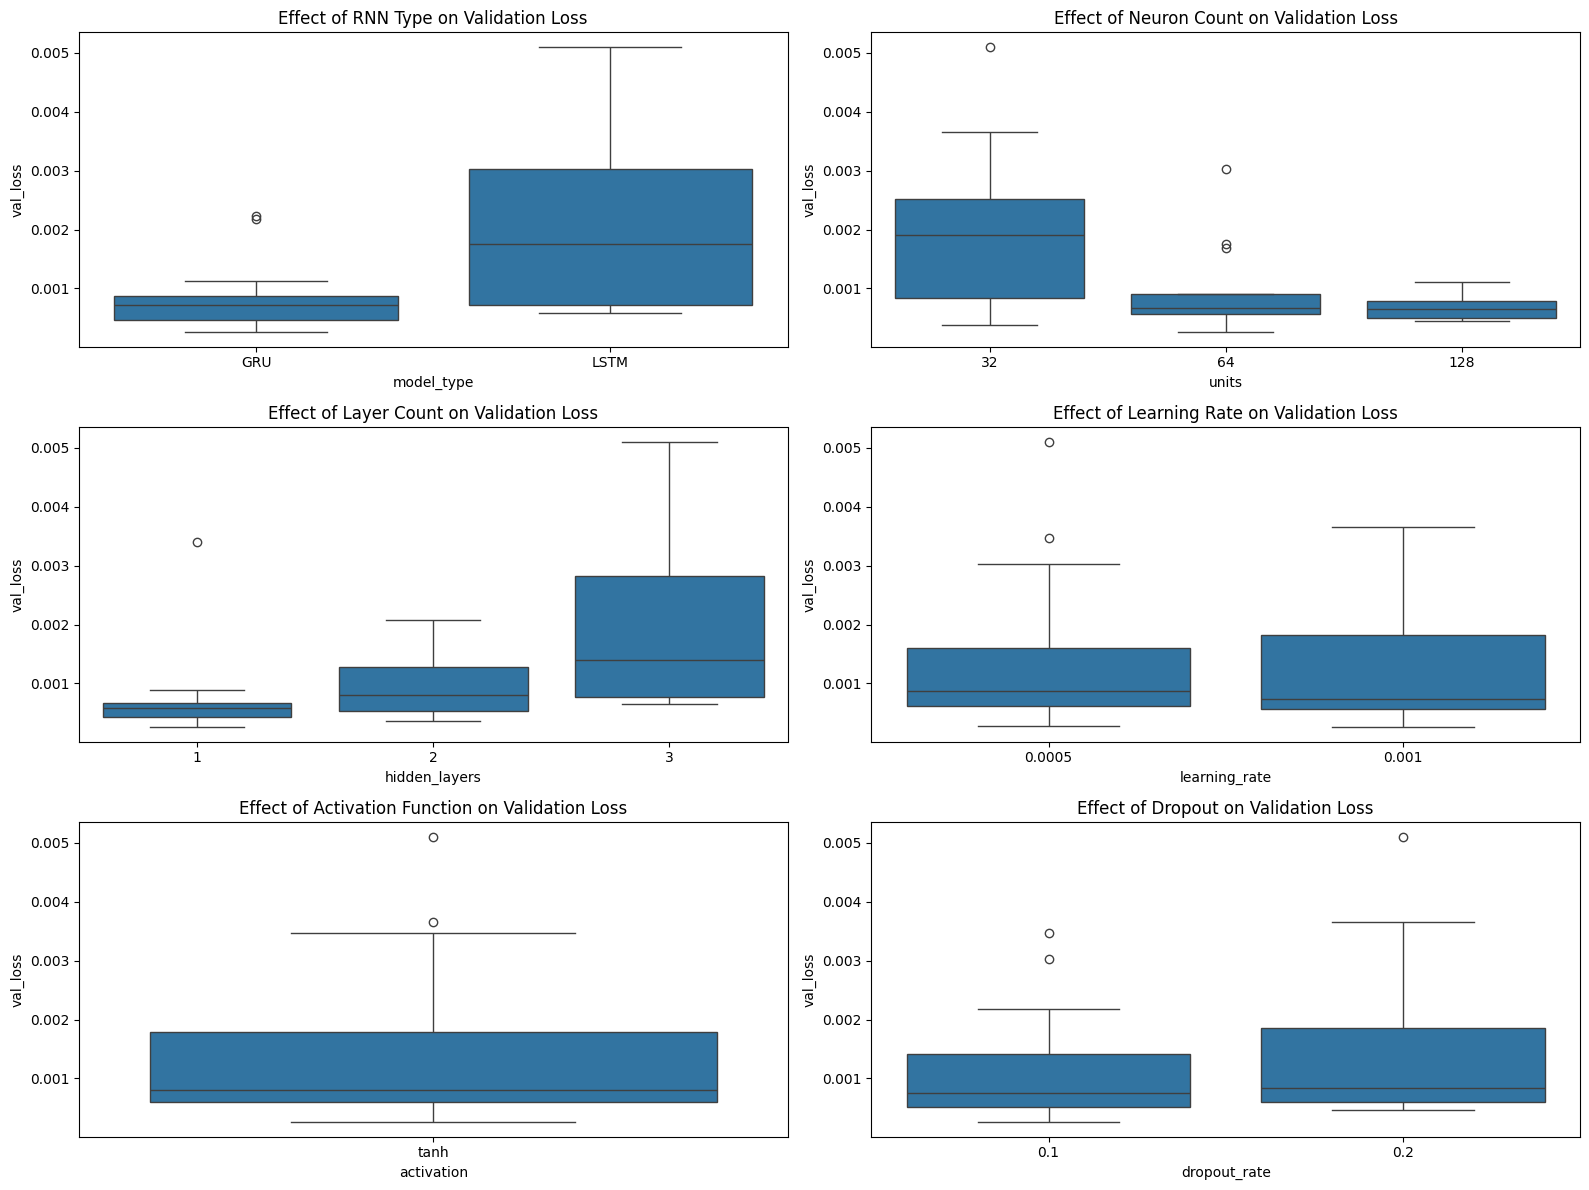

In [ ]:
# Find the best configuration LSTM
# Sort results by validation loss
results_df = adv_results_df.sort_values('val_loss')

# Display top 5 configurations
print("Top 5 best configurations:")
print(results_df.head())

# Display best parameters
best_params = results_df.iloc[0]
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

best_val_loss = best_params['val_loss']
print(f"Best validation loss: {best_val_loss:.6f}")

# Visualize impact of parameters on validation loss
plt.figure(figsize=(16, 12))

# Plot RNN type vs. validation loss
plt.subplot(3, 2, 1)
sns.boxplot(x='model_type', y='val_loss', data=results_df)
plt.title('Effect of RNN Type on Validation Loss')

# Plot neurons vs. validation loss
plt.subplot(3, 2, 2)
sns.boxplot(x='units', y='val_loss', data=results_df)
plt.title('Effect of Neuron Count on Validation Loss')

# Plot layers vs. validation loss
plt.subplot(3, 2, 3)
sns.boxplot(x='hidden_layers', y='val_loss', data=results_df)
plt.title('Effect of Layer Count on Validation Loss')

# Plot learning rate vs. validation loss
plt.subplot(3, 2, 4)
sns.boxplot(x='learning_rate', y='val_loss', data=results_df)
plt.title('Effect of Learning Rate on Validation Loss')

# Plot activation function vs. validation loss
plt.subplot(3, 2, 5)
sns.boxplot(x='activation', y='val_loss', data=results_df)
plt.title('Effect of Activation Function on Validation Loss')

# Plot dropout vs. validation loss
plt.subplot(3, 2, 6)
sns.boxplot(x='dropout_rate', y='val_loss', data=results_df)
plt.title('Effect of Dropout on Validation Loss')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,577 (64.75 KB)

 Trainable params: 16,577 (64.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0527 - val_loss: 0.1002
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0491
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0270
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6769e-04 - val_loss: 0.0041
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6932e-04 - val_loss: 0.0017
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8514e-04 - val_loss: 0.0013
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5526e-04 - val_loss: 0.0019
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5745e-04 - val_loss: 0.0019
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3850e-04 - val_loss: 8.8936e-04
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━

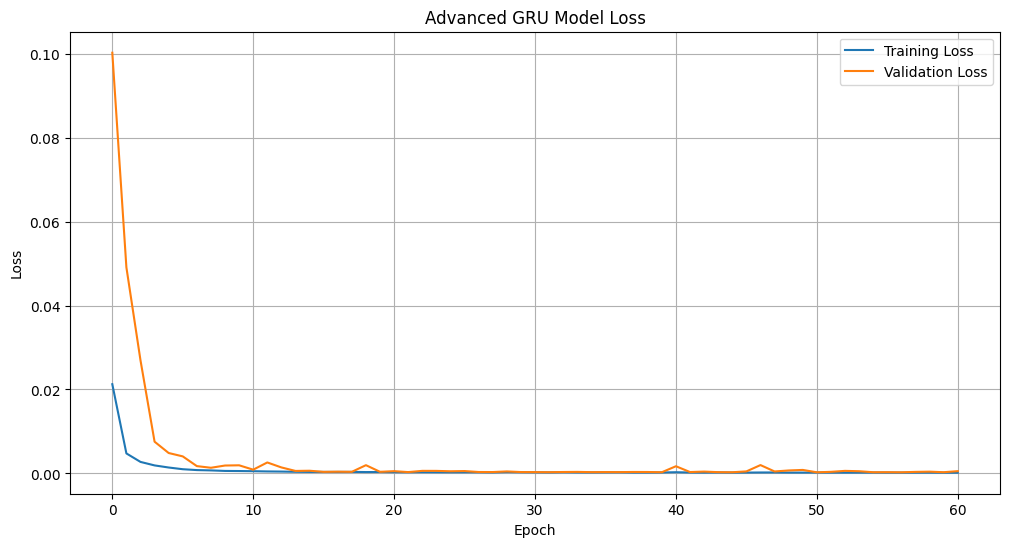

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
# Use the best parameters identified in the previous step
best_adv_model_type = best_params['model_type']
best_adv_hidden_layers = int(best_params['hidden_layers'])
best_adv_units = int(best_params['units'])
best_adv_dropout_rate = best_params['dropout_rate']
best_adv_learning_rate = best_params['learning_rate']
best_adv_activation = best_params['activation']
best_adv_bidirectional = best_params['bidirectional']


# Reset the session for clean training
tf.keras.backend.clear_session()

# Create the model with best hyperparameters
best_adv_rnn_model = create_advanced_rnn_model(
    input_shape=input_shape,
    output_dim=output_dim,
    model_type=best_adv_model_type,
    units=best_adv_units,
    dropout_rate=best_adv_dropout_rate,
    learning_rate=best_adv_learning_rate,
    hidden_layers=best_adv_hidden_layers,
    activation=best_adv_activation,
    bidirectional=best_adv_bidirectional
)

# Print model summary
best_adv_rnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with the optimal configuration
history = best_adv_rnn_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Advanced {best_adv_model_type} Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
best_adv_rnn_model.save(f'best_{best_adv_model_type.lower()}_model.h5')

In [ ]:
# Compute the performance of the model on the testing data set
# Make predictions
y_adv_pred_scaled = best_adv_rnn_model.predict(X_test_scaled)

# Inverse transform to get actual values
y_adv_pred_actual = target_scaler.inverse_transform(y_adv_pred_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_adv_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_adv_pred_actual)
r2 = r2_score(y_test_actual, y_adv_pred_actual)

print(f"Advanced {best_params['model_type']} Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Calculate percentage error
pct_error = np.abs((y_test_actual - y_adv_pred_actual) / y_test_actual) * 100
mean_pct_error = np.mean(pct_error)
print(f"Mean Absolute Percentage Error (MAPE): {mean_pct_error:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Advanced GRU Model Performance Metrics:
Mean Squared Error (MSE): 4229.2265
Root Mean Squared Error (RMSE): 65.0325
Mean Absolute Error (MAE): 53.7162
R-squared (R²): 0.8673
Mean Absolute Percentage Error (MAPE): 6.17%


Plotting the actual vs predicted values

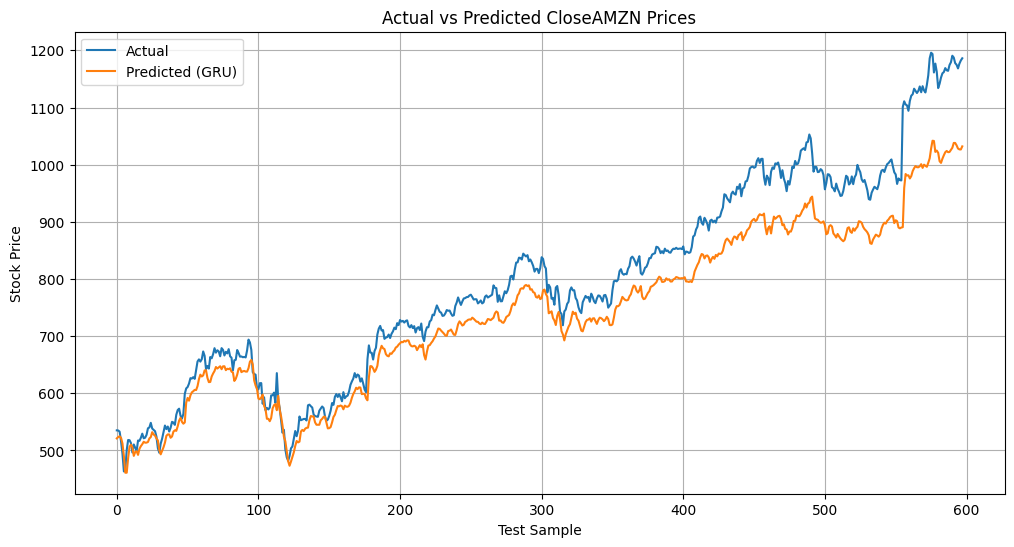

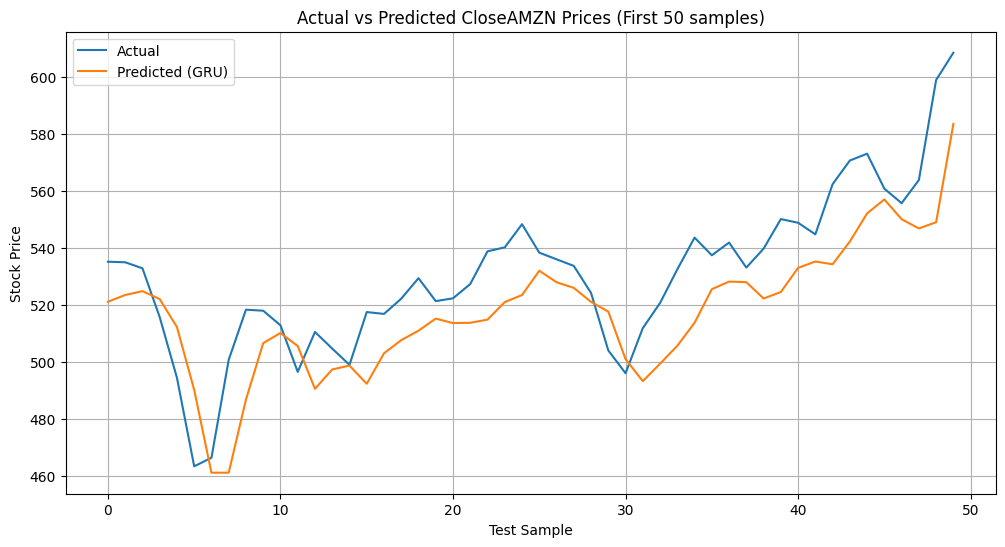

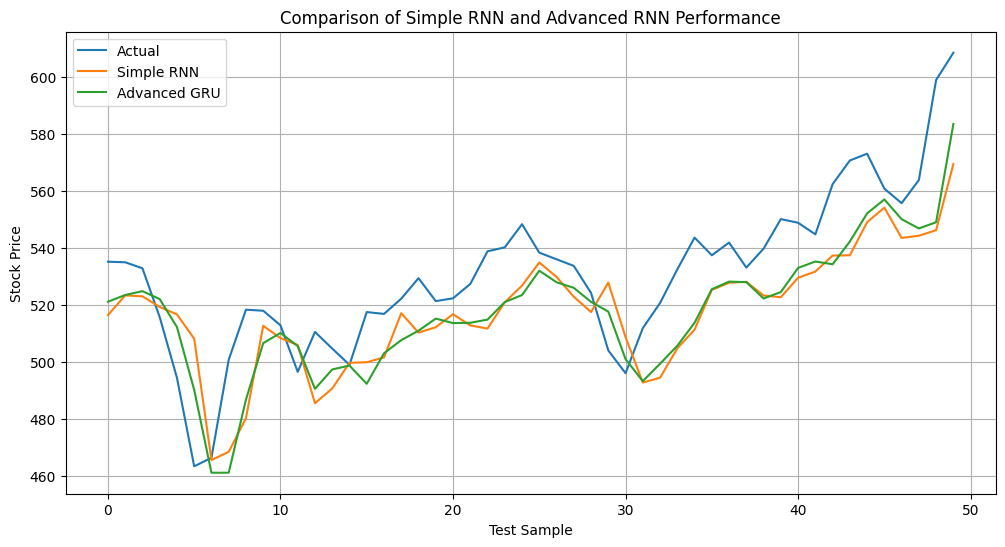

In [ ]:
# Predict on the test data
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_adv_pred_actual, label=f'Predicted ({best_params["model_type"]})')
plt.title(f'Actual vs Predicted {single_target[0]} Prices')
plt.xlabel('Test Sample')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot a subset of data for better visualization
subset_size = min(50, len(y_test_actual))
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:subset_size], label='Actual')
plt.plot(y_adv_pred_actual[:subset_size], label=f'Predicted ({best_params["model_type"]})')
plt.title(f'Actual vs Predicted {single_target[0]} Prices (First {subset_size} samples)')
plt.xlabel('Test Sample')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Compare Simple RNN vs Advanced RNN
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:subset_size], label='Actual')
plt.plot(y_pred_actual[:subset_size], label='Simple RNN')
plt.plot(y_adv_pred_actual[:subset_size], label=f'Advanced {best_params["model_type"]}')
plt.title('Comparison of Simple RNN and Advanced RNN Performance')
plt.xlabel('Test Sample')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%



In [ ]:
# Check the number of data points generated


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration


In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model


In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets




#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
In this project, Recurrent Neural Networks (RNNs) were effectively employed to predict stock prices using historical stock data from four major technology companies: IBM, Google, Amazon, and Microsoft. The problem leveraged the sequential nature of stock price data, making it ideal for RNN-based architectures.

**The study followed a structured approach:**

**Data Aggregation and Preprocessing:**

- Combined stock datasets from four companies.

- Standardized and normalized features to prepare them for sequential modeling.

- Created time-series datasets with sliding windows for training and testing.

**Model Development:**

- Two types of RNN models were explored:

1. Simple RNN

2. Advanced RNNs (including LSTM, GRU, and Bidirectional layers)

- Extensive randomized hyperparameter search was performed to identify optimal configurations for each model type.

**Performance Comparison:**

Both models were evaluated using metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² Score.

- Advanced RNNs outperformed Simple RNNs consistently, achieving better accuracy and lower prediction error across multiple target stocks.
Simple RNN R2 Score = 0.6105
Advanced RNN R2 Score = 0.8673
- The use of Bidirectional layers and GRU/LSTM components significantly improved the model's ability to capture long-term dependencies in stock movements.

**Visualizations:**

- Actual vs. Predicted plots demonstrated that the advanced RNNs closely tracked real stock prices with smaller deviations.

### Final Insights
- Advanced RNN architectures, particularly those incorporating LSTM or GRU layers with dropout regularization, are well-suited for time-series forecasting of stock data.

- Hyperparameter tuning via random search proved crucial in enhancing performance.

- Using data from multiple companies in the same sector provided a richer signal and helped improve generalization.

- These models can serve as the foundation for more complex financial forecasting systems, potentially integrating sentiment data or macroeconomic indicators.